# Fitting COSMOS galaxes with MultiProFit

This notebook plots results from fitting galaxies from the COSMOS survey (http://cosmos.astro.caltech.edu/) with MultiProFit. This investigation is to help determine what kind of galaxy models LSST Data Management should fit for annual Data Releases, where we would like to fit the best possible model(s) but will be constrained in computing time by the overwhelming size of the dataset (billions of objects).

A couple of other points need to be addressed before moving on:

1. Why COSMOS? COSMOS has a full square degree of very deep, high-resolution Hubble Space Telescope (HST) imaging in the F814W band. This matches up nicely with the slightly deeper but lower resolution ground-based grizy imaging from Subaru Hyper-Suprime Cam (HSC). The approach we take here is to fit the HST images first, the higher resolution being preferable for resolved features like compact bulges and for minimizing the impact of blending (overlapping sources). We then fit HSC-UltraDeep images, which are of comparable resolution and depth to 10-year LSST images (actually slightly better resolution and deeper, but that's fine). An intermediate step involves taking a best-fit HST model, generating a mock HSC-quality image, and then fitting this mock image. This is meant to gauge how well the true parameters are recovered both in cases where we used the correct model - that is, when the model used to fit HSC-quality data can perfectly represent the true HST model - and also to measure the bias when fitting wrong models that can't represent the true galaxy profile exactly.

2. All of the models tested here are either a) traditional Sersic profiles or b) Gaussian mixture models (GMMs). In fact, most of the 'Sersic' are multi-Gaussian approximations thereof (MGAs). For more details, see this notebook on deriving optimal MGAs for the Sersic profile: https://github.com/lsst-dm/modelling_research/blob/master/jupyternotebooks/multigaussian_sersic1d.ipynb.

### Fitting galaxies

Firstly, you'll need to install MultiProFit, available here: https://github.com/lsst-dm/multiprofit.

To fit true Sersic models, you'll need one of GalSim: https://github.com/GalSim-developers/GalSim/ or PyProFit: https://github.com/ICRAR/pyprofit/. Despite the fact that I am an author of ProFit, I suggest using GalSim as its rendering methods are faster and/or more robust in most cases. The only exception is that its more stringent accuracy requirements mean that it can be much slower or consume large amounts of RAM evaluating some parameter combinations, but that's more of an indictment of the Sersic profile than of GalSim.

For fitting HST images, these scripts make use of the GalSim COSMOS 25.2 training sample, available here: https://github.com/GalSim-developers/GalSim/wiki/RealGalaxy%20Data. This sample is designed to test algorithms for weak lensing shear measurements, which typically have stricter requirements than galaxy models for galaxy evolution science.

For fitting HSC images, these scripts make use of the LSST software pipelines (https://github.com/lsst/) to access data available on LSST servers. HSC periodically releases data publicly and you can 'quarry' (download images) from here after registering an account: https://hsc-release.mtk.nao.ac.jp/doc/index.php/tools/. The older PyProFit fork had an example script that used this public data (https://github.com/lsst-dm/pyprofit/blob/master/examples/hsc.py), but this is not yet available in MultiProFit.

This notebook does not yet actually show the results of fitting HSC images; instead, it takes a best-fit HST model, degrades it to HSC resolution using the actual i-band HSC PSF, and then adds noise according to the observed variance map. These measurements essentially measure only the effects of noise bias on the recovered galaxy properties for isolated galaxies, although deblending (contamination from overlapping sources) is also an issue in HSC and occasionally even in HST - that's a subject for another day. It's worth noting that the HST filter used in COSMOS (F814W; http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=HST/WFPC2.f814w) approximately covers HSC/SDSS i- and z-bands (http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?mode=browse&gname=Subaru&gname2=HSC), so a multi-band fit to HSC i+z should also be consistent with HST F814W. For single-band fits, HSC-I is more convenient as it is broader, tends to have better seeing and covers a larger fraction of F814W.

Multi-band fitting is possible in principle but not yet fully implemented.

### Galaxy fitting scripts

The data analyzed here were generated using MultiProFit's fitcosmos.py example script (https://github.com/lsst-dm/multiprofit/blob/master/examples/fitcosmos.py).

MultiProFit allows for flexible fitting workflows specified in a CSV; the specifications used here are kept in this repo as well: https://github.com/lsst-dm/modelling_research/blob/master/cosmos/modelspecs-hst-mg.csv

fitcosmos.py was run in batches of 100 galaxies using the following invocations. The choice of batches isn't important; you could output one file per galaxy if you so desired. The exact commands run are as follows:

#Fit Sersic-family models to HST images
python ~/src/mine/multiprofit/examples/fitcosmos.py -catalogpath ~/raid/hsc/cosmos/COSMOS_25.2_training_sample/ -catalogfile real_galaxy_catalog_25.2.fits -indices 0,100 -fithst 1 -modelspecfile ~/raid/lsst/cosmos/modelspecs-hst.csv -fileout ~/raid/lsst/cosmos/cosmos_25.2_fits_0_100_pickle.dat > ~/raid/lsst/cosmos/cosmos_25.2_fits_0_100.log 2>~/raid/lsst/cosmos/cosmos_25.2_fits_0_100.err &
#Fit GMMs to HST images
python ~/src/mine/multiprofit/examples/fitcosmos.py -catalogpath ~/raid/hsc/cosmos/COSMOS_25.2_training_sample/ -catalogfile real_galaxy_catalog_25.2.fits -indices 0,100 -fithst 1 -modelspecfile ~/raid/lsst/cosmos/modelspecs-hst-mg.csv -fileout ~/raid/lsst/cosmos/cosmos_25.2_fits_0_100_pickle.dat -redo 0 > ~/raid/lsst/cosmos/cosmos_25.2_fits_0_100_mg8.log 2>~/raid/lsst/cosmos/cosmos_25.2_fits_0_100_mg8.err &
#Fit all models to realistic mock HSC images taking the HST Sersic fit as the ground truth
python ~/src/mine/multiprofit/examples/fitcosmos.py -catalogpath ~/raid/hsc/cosmos/COSMOS_25.2_training_sample/ -catalogfile real_galaxy_catalog_25.2.fits -indices 0,100 -fithst2hsc 1 -modelspecfile ~/raid/lsst/cosmos/modelspecs-hsc-mg.csv -redo 0 -fileout ~/raid/lsst/cosmos/cosmos_25.2_fits_0_100_pickle.dat -hst2hscmodel mgserbpx > ~/raid/lsst/cosmos/cosmos_25.2_fits_0_100_hst2hsc_ser.log 2>~/raid/lsst/cosmos/cosmos_25.2_fits_0_100_hst2hsc_ser.err &

### Analyze the results

Import required packages and set matplotlib/seaborn defaults for slightly nicer plots.

In [1]:
import astropy as ap
import galsim as gs
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns

# Setup for plotting
%matplotlib inline

#plt.style.use('seaborn-notebook')
sns.set_style('darkgrid')
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['image.origin'] = 'lower'
sns.set(rc={'axes.facecolor': '0.85', 'figure.facecolor': 'w'})

### Compute R_eff for MGA

These functions compute the effective (half-light) radius R_eff for MGA profiles. These should almost exactly equal the nominal Sersic R_eff for the Sersic MGA for values of n fitted over the full range of r/R_eff, but for n>2 the truncation at large radii and any exclusion of the inner part of the profile from the fit will change R_eff. Also, this can be used to measure R_eff for any Gaussian mixture model consisting of components with shared ellipse parameters (i.e. isophote shapes).

In [2]:
# https://www.wolframalpha.com/input/?i=Integrate+2*pi*x*exp(-x%5E2%2F(2*s%5E2))%2F(s*sqrt(2*pi))+dx+from+0+to+r
# The fraction of the total flux of a 2D Sersic profile contained within r
# For efficiency, we can replace r with r/sigma.
# Note the trivial renormalization allows us to drop annoying sigma and pi constants - it returns (0, 1) for inputs of (0, inf)
def gauss2dint(xdivsigma):
     return 1 - np.exp(-xdivsigma**2/2.)


# Compute the integrated flux to some radius x for a sum of Gaussians
# x is a length in arbitrary units
# Weightsizes is a list of tuples of the weight (total flux) and size (r_eff in the same units as x) of each gaussian
# Note that gauss2dint expects x/sigma, but size is re, so we pass x/re*re/sigma = x/sigma
# 0 > quant > 1 turns it into a function that returns zero at the value of x containing a fraction quant of the total flux
# This is so you can use root finding algorithms to find x for a given quant (see below)
def multigauss2dint(x, weightsizes, quant=0):
     retosigma = np.sqrt(2.*np.log(2.))
     weightsum = -quant
     for weight, size in weightsizes:
         weightsum += weight*gauss2dint(x/size*retosigma)
     return weightsum


import scipy.optimize as spopt
# Compute x_quant for a sum of Gaussians, where 0<quant<1
# There's probably an analytic solution to this if you care to work it out
# Weightsizes and quant are as above
# Choose xmin, xmax so that xmin < x_quant < xmax. Ideally we'd just set xmax=np.inf but brentq doesn't work then
def multigauss2drquant(weightsizes, quant=0.5, xmin=0, xmax=1e5):
    return spopt.brentq(multigauss2dint, a=xmin, b=xmax, args=(weightsizes, quant))

### Read COSMOS catalog and pickled MultiProFit results

The example script to generate these results can be found at https://github.com/lsst-dm/multiprofit/blob/master/examples/fitcosmos.py (for now).

The COSMOS catalog is from GalSim: https://github.com/GalSim-developers/GalSim/wiki/RealGalaxy-Data

In [3]:
path = os.path.expanduser('~/raid/hsc/cosmos/COSMOS_25.2_training_sample/')
file = "real_galaxy_catalog_25.2.fits"
ccat = gs.COSMOSCatalog(file, dir=path)
rgcfits = ap.io.fits.open(os.path.join(path, file))[1].data

In [4]:
data = []
 
files = glob.glob(os.path.expanduser(
    "~/raid/lsst/cosmos/cosmos_25.2_fits_*_*_pickle.dat"))
files.sort()
for file in files:
    with open(file, 'rb') as f:
        data.append(pickle.load(f))

### Define the table column names

This (admitted ugly) section defines column names and indices for reading both the MultiProFit fit results and the results from the COSMOS-GalSim catalog itself for a consistency check.

In [5]:
# See https://github.com/GalSim-developers/GalSim/blob/8d9bc8ce568e3fa791ab658650fce592cdf03735/galsim/scene.py
# lines 615-625
# Presumably copypasta'd from the original COSMOS fit catalog table/paper

#     SERSICFIT[0]: intensity of light profile at the half-light radius.
#     SERSICFIT[1]: half-light radius measured along the major axis, in units of pixels
#                   in the COSMOS lensing data reductions (0.03 arcsec).
#     SERSICFIT[2]: Sersic n.
#     SERSICFIT[3]: q, the ratio of minor axis to major axis length.
#     SERSICFIT[4]: boxiness, currently fixed to 0, meaning isophotes are all
#                   elliptical.
#     SERSICFIT[5]: x0, the central x position in pixels.
#     SERSICFIT[6]: y0, the central y position in pixels.
#     SERSICFIT[7]: phi, the position angle in radians.  If phi=0, the major axis is
#                   lined up with the x axis of the image.

sources = ["hst"] + ["_".join(["hst2hsc", postfix]) for postfix in [
#    "",
    "mg8serbpx",
#    "_devexp"
]]
params = {
    "cosmos": ["IDENT", "mag_auto", "flux_radius", "zphot", "use_bulgefit", "viable_sersic"],
    "profit": ["chisqred", "time"],
}
# Some hideous code to get all of the column names in the right order
# See above for COSMOS fits param order
idxparamscosmos = [[x + offset for x in [1, 2, 3, 7, 5, 6]] for offset in [0, 8]]
# profit was setup to output [cenx, ceny, flux, fluxrat, re, axrat, ang, nser]
idxprofit = [2, 4, 7, 5, 6, 0, 1]
idxprofittwo = [3, 4, 7, 5, 6, 0, 1, 8, 9, 12, 10, 11, 0, 1]
idxprofitmg8 = [2, 4, 5, 6, 0, 1, 3, 8, 13, 18, 23, 28, 33, 38, 4, 9, 14, 19, 24, 29, 34, 39]
idxprofitmg4 = [2, 4, 5, 6, 0, 1, 3, 8, 13, 18, 4, 9, 14, 19]
idxprofitmg4x2 = [2, 4, 5, 6, 0, 1, 3, 8, 13, 18, 23, 28, 33, 38, 4, 9, 14, 19, 24, 29, 34, 39, 24, 25, 26]

orders = ['8', '4']
idxparamsprofit = {
    "gausspx":     idxprofit,
}
mgmodels = {
    order: ['mg' + order + model + 'px' for model in ['exp', 'n2', 'dev2', 'serb', 'serbed']]
    for order in orders
}
for order in orders:
    for model in mgmodels[order]:
        idxparamsprofit[model] = idxprofit
idxparamsprofit.update(
    {
        "serbpx":  idxprofit,
        "serb":  idxprofit,
        "mg8bpx": idxprofitmg8,
        "mg4bpx": idxprofitmg4,
        "mg4x2px": idxprofitmg4x2
    }
)
mgmodelstwo = {
    order: ['mg' + order + model + 'px' for model in ['cmodel', 'devexp', 'devexpc', 'serserb']]
    for order in orders
}
for order in orders:
    for model in mgmodelstwo[order]:
        idxparamsprofit[model] = idxprofittwo
print(idxparamsprofit)

paramsser = ["flux", "re", "n", "q", "phi", "x0", "y0"]
paramsmg8 = ["flux", "re", "q", "phi", "x0", "y0", 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8']
paramsmg4 = ["flux", "re", "q", "phi", "x0", "y0", 'f1', 'f2', 'f3', 'f4', 'r1', 'r2', 'r3', 'r4']
paramsmg4x2 = ["flux", "re", "q", "phi", "x0", "y0", 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 're2', 'q2', 'phi2']
# Keep track of the 're' field for Gaussian mixture models and the indices of the weights and sizes of each component
idxmgweightsizes = {
    '4': [(1, np.arange(6, 6+4), np.arange(10, 10+4))],
    '8': [(1, np.arange(6, 6+8), np.arange(14, 14+8))],
    '4x2': [(1, np.arange(6, 6+4), np.arange(14, 14+4)), (22, np.arange(10, 10+4), np.arange(18, 18+4))],
}
paramweightsizeskeymodel = {
    'mg8bpx': (paramsmg8, '8'),
    'mg4bpx': (paramsmg4, '4'),
    'mg4x2px': (paramsmg4x2, '4x2'),
}
models = {
    "single": {
        "cosmos": ["ser"],
        "profit": ["gausspx"] + mgmodels['8'] + mgmodels['4'] + ["serbpx", "serb"],
    },
    "double": {
        "cosmos": ["devexp"],
        "profit": mgmodelstwo['8'] + mgmodelstwo['4'],
    },
    "mg": {
        "cosmos": [],
        "profit": ["mg8bpx", "mg4bpx", "mg4x2px"],
    },
}
modellers = {
    "cosmos": [None],
    "profit": sources,
}
colnames = {
    modeller if src is None else ".".join([modeller, src]): 
        [".".join([model, param]) for model in models["single"][modeller] for param in paramsser] +
        [".".join([model, param]) for model in models["mg"][modeller] for param in paramweightsizeskeymodel[model][0]] +
        [".".join([model, param]) for model in models["double"][modeller] for param in
         [comp + "." + param for comp in ["exp", "dev"] for param in paramsser]]
    for modeller, srcs in modellers.items() for src in srcs
}
colnames = (["id", "ra", "dec"] +
            [".".join(["cosmos", param]) for param in params["cosmos"]] +
            [".".join(["profit", src, model, param, str(idx)])
             for src in sources
             for model in idxparamsprofit.keys()
             for param in params["profit"]
             for idx in range(1 + (model in models['double']['profit'] or model in models['mg']['profit']))] +
            [".".join([prefix, x]) for prefix, colnames in colnames.items() for x in colnames])

print(colnames)
print(len(colnames))

{'gausspx': [2, 4, 7, 5, 6, 0, 1], 'mg8exppx': [2, 4, 7, 5, 6, 0, 1], 'mg8n2px': [2, 4, 7, 5, 6, 0, 1], 'mg8dev2px': [2, 4, 7, 5, 6, 0, 1], 'mg8serbpx': [2, 4, 7, 5, 6, 0, 1], 'mg8serbedpx': [2, 4, 7, 5, 6, 0, 1], 'mg4exppx': [2, 4, 7, 5, 6, 0, 1], 'mg4n2px': [2, 4, 7, 5, 6, 0, 1], 'mg4dev2px': [2, 4, 7, 5, 6, 0, 1], 'mg4serbpx': [2, 4, 7, 5, 6, 0, 1], 'mg4serbedpx': [2, 4, 7, 5, 6, 0, 1], 'serbpx': [2, 4, 7, 5, 6, 0, 1], 'serb': [2, 4, 7, 5, 6, 0, 1], 'mg8bpx': [2, 4, 5, 6, 0, 1, 3, 8, 13, 18, 23, 28, 33, 38, 4, 9, 14, 19, 24, 29, 34, 39], 'mg4bpx': [2, 4, 5, 6, 0, 1, 3, 8, 13, 18, 4, 9, 14, 19], 'mg4x2px': [2, 4, 5, 6, 0, 1, 3, 8, 13, 18, 23, 28, 33, 38, 4, 9, 14, 19, 24, 29, 34, 39, 24, 25, 26], 'mg8cmodelpx': [3, 4, 7, 5, 6, 0, 1, 8, 9, 12, 10, 11, 0, 1], 'mg8devexppx': [3, 4, 7, 5, 6, 0, 1, 8, 9, 12, 10, 11, 0, 1], 'mg8devexpcpx': [3, 4, 7, 5, 6, 0, 1, 8, 9, 12, 10, 11, 0, 1], 'mg8serserbpx': [3, 4, 7, 5, 6, 0, 1, 8, 9, 12, 10, 11, 0, 1], 'mg4cmodelpx': [3, 4, 7, 5, 6, 0, 1, 8, 9,

### Read the MultiProFit results

Continuing the trend of unseemly code, this section reads every MultiProFit result pickle and saves a row with numbers in the same order as the column names above. TBD: Combine these into one.

In [6]:
# Some hideous code to get all of the right values in the right order, for which I apologize

# The COSMOS catalog has fewer objects than the RealGalaxyCatalog for ??? reasons
# Get the mapping between RGC indices (which is what I used) and CosmosCat ones (for previous fits)
indexmap = {ccat.getOrigIndex(i): i for i in range(ccat.getNObjects())}

rows = []

# Shouldn't have hardcoded this but here we are
scaleratio = 0.168/0.03
verbose = False
printrow = True
for datatab in data:
    appended = 0
    for idx in datatab:
        hasfits = False
        if isinstance(datatab[idx], dict) and idx in indexmap:
            hasfits = True
            row = [idx] + list(rgcfits[idx][1:3])
            rec = ccat.getParametricRecord(indexmap[idx])
            row += [rec[param] for param in params["cosmos"]]
            for src in sources:
                stage = 0
                hasfits = hasfits and src in datatab[idx]
                if hasfits:
                    stage = 1
                    profit = datatab[idx][src]
                    hasfits = hasfits and 'fits' in profit
                    if hasfits:
                        stage = 2
                        profit = profit['fits']
                        for model in idxparamsprofit:
                            hasfits = hasfits and model in profit['galsim']
                            if hasfits:
                                stage = 3
                                profitmodel = profit['galsim'][model]
                                hasfits = hasfits and 'fits' in profitmodel
                                if hasfits:
                                    stage = 4
                                    profitmodel = profitmodel['fits']
                                    row += [profitmodelfit[param]
                                            for param in params["profit"]
                                            for profitmodelfit in profitmodel]
                                    if printrow:
                                        print(src, idx, len(row), model, params['profit'], len(profitmodel), hasfits)
                                elif verbose:
                                    print(src, idx, model, profitmodel.keys(), hasfits, stage)
                            elif verbose:
                                print(src, idx, model, profit['galsim'].keys(), hasfits, stage)
                    elif verbose:
                        print(src, idx, model, profit.keys(), hasfits, stage)
                elif verbose:
                    print(src, idx, datatab[idx].keys(), model, hasfits, stage)
                if printrow:
                    print(src, idx, datatab[idx].keys(), model, hasfits, stage)
            if hasfits:
                row += [rec["flux"][0]] + list(rec["sersicfit"][idxparamscosmos[0]])
                if printrow:
                    print(len(row), 'cosmos.ser')
                for offset in range(2):
                    row += [rec["flux"][1+offset]] + list(rec["bulgefit"][idxparamscosmos[offset]])
                    if printrow:
                        print(len(row), 'cosmos.devexp.' + str(offset))
                for src in sources:
                    profit = datatab[idx][src]['fits']
                    for model, idxs in idxparamsprofit.items():
                        twocomp = model in models['double']['profit']
                        values = np.array(profit['galsim'][model]['fits'][-1]["paramsbestall"])
                        if 'fluxscalehst2hsc' in datatab[idx][src]['metadata']:
                            values[2] /= datatab[idx][src]['metadata'][
                                'fluxscalehst2hsc']
                            values[4] *= scaleratio
                        if twocomp:
                            # Subtract first component fluxfrac
                            values[8] = 1 - values[3]
                            values[9] *= scaleratio
                            for col in [3, 8]:
                                values[col] *= values[2]
                        # This is a bit ugly - replace the placeholder re value with a proper calculation
                        if model in models['mg']['profit']:
                            idxs = np.array(idxs)
                            for idxsparams in idxmgweightsizes[paramweightsizeskeymodel[model][1]]:
                                weights = values[idxs[idxsparams[1]]]
                                weightsum = 1.0
                                for idxweight, weight in enumerate(weights):
                                    weight *= weightsum
                                    weightsum -= weight
                                    weights[idxweight] = weight
                                # Ensure that the weights sum to unity += machine eps.
                                weights[-1] = 1.0-np.sum(weights[:-1])
                                sizes = values[idxs[idxsparams[2]]]
                                values[idxs[idxsparams[0]]] = multigauss2drquant(list(zip(weights, sizes)))
                        row += list(values[idxs])
                        if printrow:
                            print(len(row), model)
                    printrow = False
        if hasfits:
            rows.append(row)
            appended += 1
    listids = datatab.keys()
    print("Read {}/{} rows from {}-{}".format(
        appended, len(datatab), min(listids),
        max(listids)))

    # TODO: Convert mu_re into flux for use_bulgefit=0
    #row += profit["paramsbest"]

hst 0 11 gausspx ['chisqred', 'time'] 1 True
hst 0 13 mg8exppx ['chisqred', 'time'] 1 True
hst 0 15 mg8n2px ['chisqred', 'time'] 1 True
hst 0 17 mg8dev2px ['chisqred', 'time'] 1 True
hst 0 19 mg8serbpx ['chisqred', 'time'] 1 True
hst 0 21 mg8serbedpx ['chisqred', 'time'] 1 True
hst 0 23 mg4exppx ['chisqred', 'time'] 1 True
hst 0 25 mg4n2px ['chisqred', 'time'] 1 True
hst 0 27 mg4dev2px ['chisqred', 'time'] 1 True
hst 0 29 mg4serbpx ['chisqred', 'time'] 1 True
hst 0 31 mg4serbedpx ['chisqred', 'time'] 1 True
hst 0 33 serbpx ['chisqred', 'time'] 1 True
hst 0 35 serb ['chisqred', 'time'] 1 True
hst 0 39 mg8bpx ['chisqred', 'time'] 2 True
hst 0 43 mg4bpx ['chisqred', 'time'] 2 True
hst 0 47 mg4x2px ['chisqred', 'time'] 2 True
hst 0 51 mg8cmodelpx ['chisqred', 'time'] 2 True
hst 0 55 mg8devexppx ['chisqred', 'time'] 2 True
hst 0 59 mg8devexpcpx ['chisqred', 'time'] 2 True
hst 0 63 mg8serserbpx ['chisqred', 'time'] 2 True
hst 0 67 mg4cmodelpx ['chisqred', 'time'] 2 True
hst 0 71 mg4devexppx 

/software/lsstsw/stack_20181012/python/miniconda3-4.5.4/envs/lsst-scipipe/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in double_scalars
  
/software/lsstsw/stack_20181012/python/miniconda3-4.5.4/envs/lsst-scipipe/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/software/lsstsw/stack_20181012/python/miniconda3-4.5.4/envs/lsst-scipipe/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/software/lsstsw/stack_20181012/python/miniconda3-4.5.4/envs/lsst-scipipe/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in double_scalars


### Writing a table with the results

The table of results isn't quite human-readable, but you can analyze it any which way you like.

In [7]:
# Write to a plain old CSV, then read it back in to double-check
import csv

with open(os.path.join(path, "galfits.csv"), "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows([colnames])
    writer.writerows(rows)
    

In [8]:
tab = pd.read_csv(os.path.join(path, "galfits.csv"))

### Make joint parameter plots

This section makes an alarmingly large number of plots. Most of them check consistency between the MultiProFit fits and the COSMOS-GalSim catalog values with marginalized histograms thereof. The last set compares the results from HST fits to synthetic HSC-quality images of the same galaxy. More specifically, we take the best-fit HST F814W model (single MG Sersic for now), convolve it with the HSC r-band PSF, re-normalize the magnitude to match the original HSC image since they're different resolutions and the F814W band is wider than r, and use the observed HSC inverse variance map (which isn't completely consistent with the 'true' model, but it's close enough and saves the effort of having to back out the HSC background, etc.).

Note that the colour coding is by log(Sersic index), such that low values (~disk-like) are blue and high values (~bulge-like) are red.

In [9]:
# How well are parameters recovered?
# First check consistency with previous fits (Sersic only for now)
# Then HSC vs HST
# TODO: Rename this: prefix -> var and var->postfix
def getname(var, prefix, postfix):
    namevar = ".".join([prefix, var]) if prefix is not None else var
    namevar = ".".join([namevar, postfix]) if postfix is not None else namevar
    return namevar


def plotjoint(tab, prefixx, prefixy, varnames, varcolor="profit.hst.mg8serbpx.n",
              cmap = mpl.colors.ListedColormap(sns.color_palette("RdYlBu_r", 100)),
              plotmarginals=True, hist_kws={'log': False}, postfixx=None, postfixy=None):
    ratios = {var: tab[getname(var, prefixx, postfixx)]/tab[getname(var, prefixy, postfixy)] for 
              var in varnames}
    colors = (np.log10(tab[varcolor])+1)/np.log10(60)
    colors = cmap(np.rint(100*colors)/100)
    for i, x in enumerate(varnames): 
        xlog = np.log10(ratios[x])
        xlog[xlog > 1] = 1
        xlog[xlog < -1] = -1
        for y in varnames[(i+1):(len(varnames)+1)]:
            namey = getname(y, prefixy, postfixy)
            ylog = np.log10(ratios[y])
            ylog[ylog > 1] = 1
            ylog[ylog < -1] = -1
            fig = sns.JointGrid(x=xlog, y=ylog)
            fig.plot_joint(plt.scatter, c=colors, marker='.',
                           edgecolor='k', s=24).set_axis_labels(
                'log10({}_ratio) ({}/{})'.format(x, prefixx, prefixy),
                'log10({}_ratio) ({}/{})'.format(y, prefixx, prefixy))
            if plotmarginals:
                fig.plot_marginals(sns.distplot, kde=False, hist_kws=hist_kws)

        ylog = np.log10(tab[getname(x, prefixx, postfixx)])
        fig = sns.JointGrid(x=ylog, y=xlog)
        fig.plot_joint(plt.scatter, c=colors, marker='.',
                       edgecolor='k', s=24).set_axis_labels(
            'log10({}) ({})'.format(x, prefixx),
            'log10({}_ratio) ({}/{})'.format(x, prefixx, prefixy))
        if plotmarginals:
            fig.plot_marginals(sns.distplot, kde=False, hist_kws=hist_kws)
        #cax = fig.add_axes([.94, .25, .02, .6])

varnames = ["flux", "re", "n"]

### COSMOS-HST: GalSim catalog Sersic fit versus MultiProfit Sersic fit

This is a sanity check comparing MultiProFit's true Sersic profile fit (albeit convolved with a 3-Gaussian PSF rather than the PSF image) compared to the values in the GalSim catalog.

The results are reasonably consistent, though not without systematic differences.

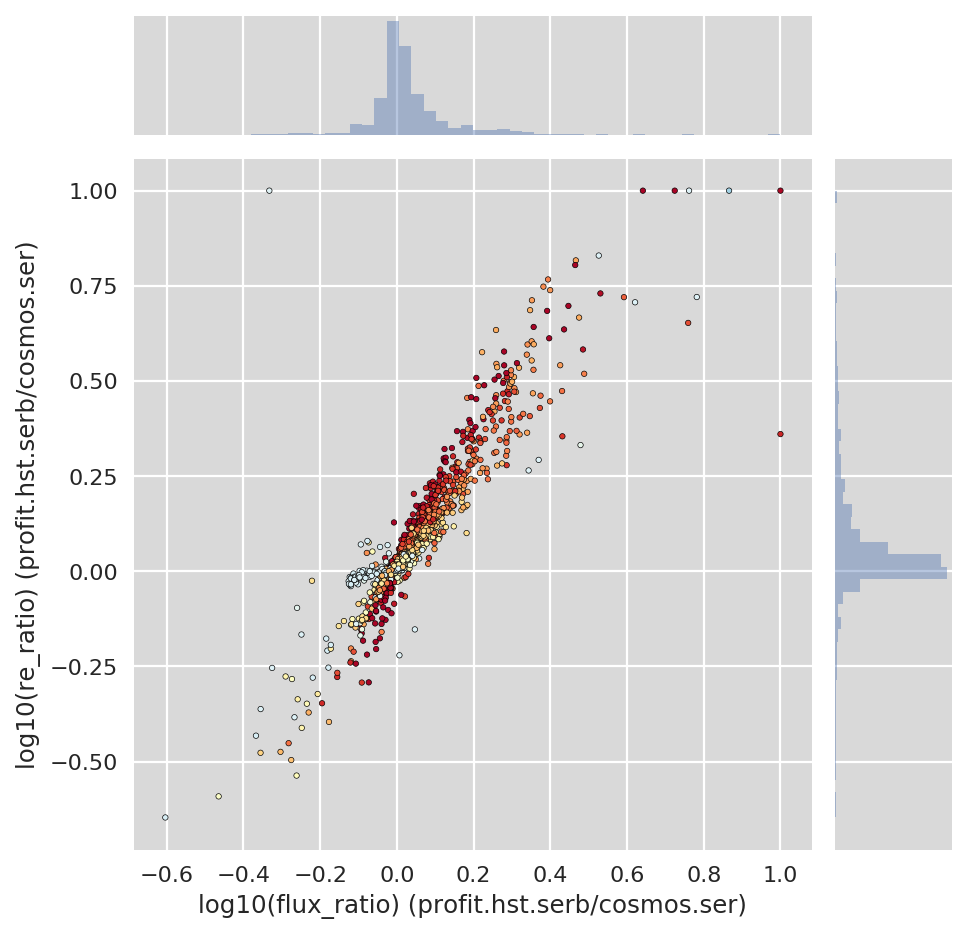

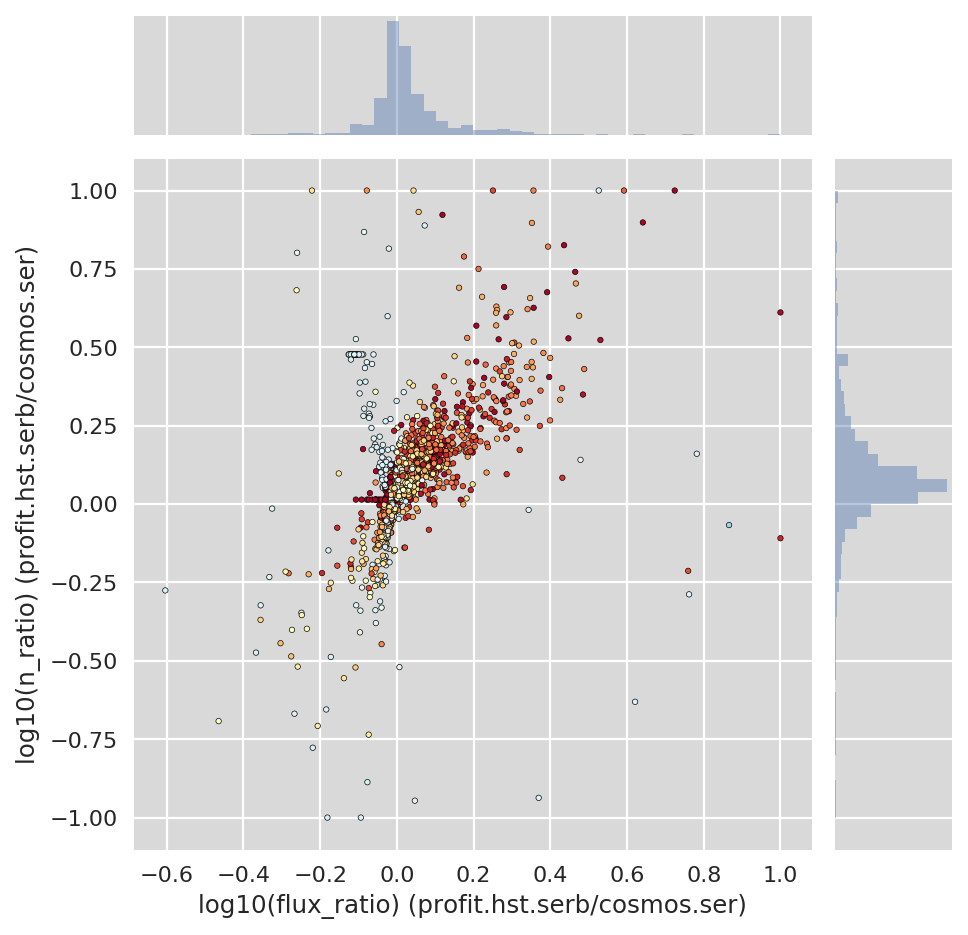

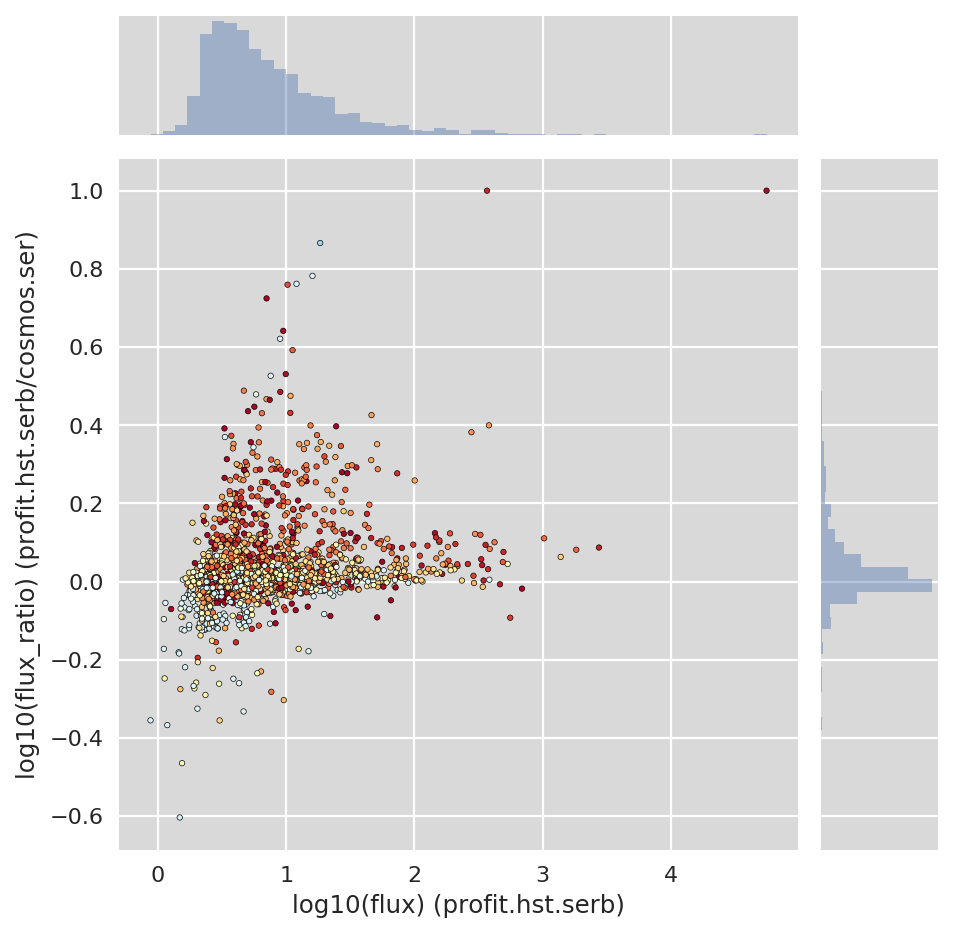

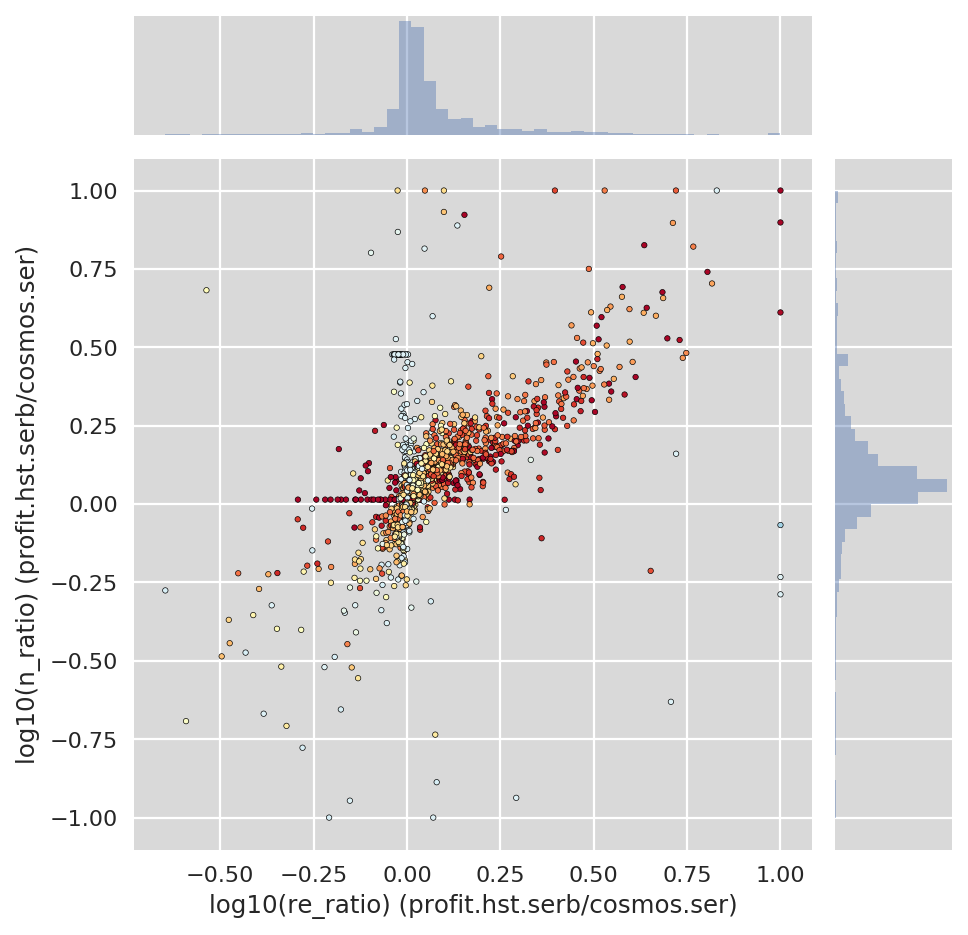

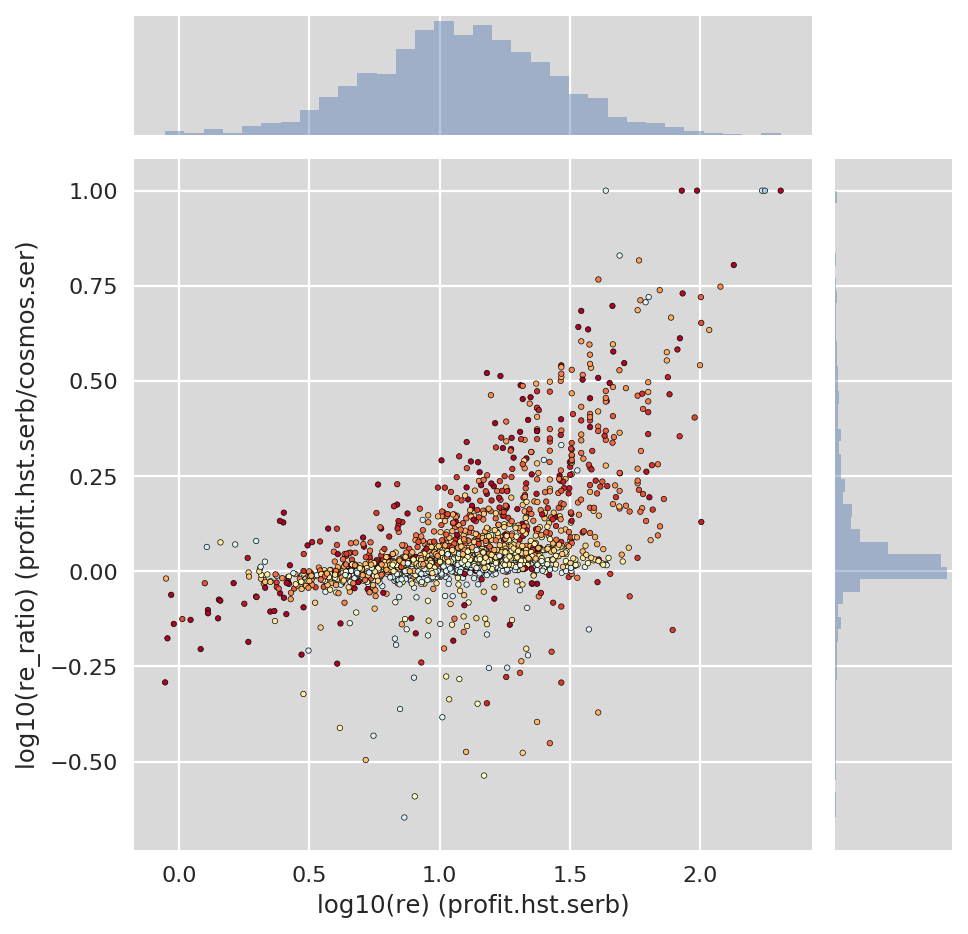

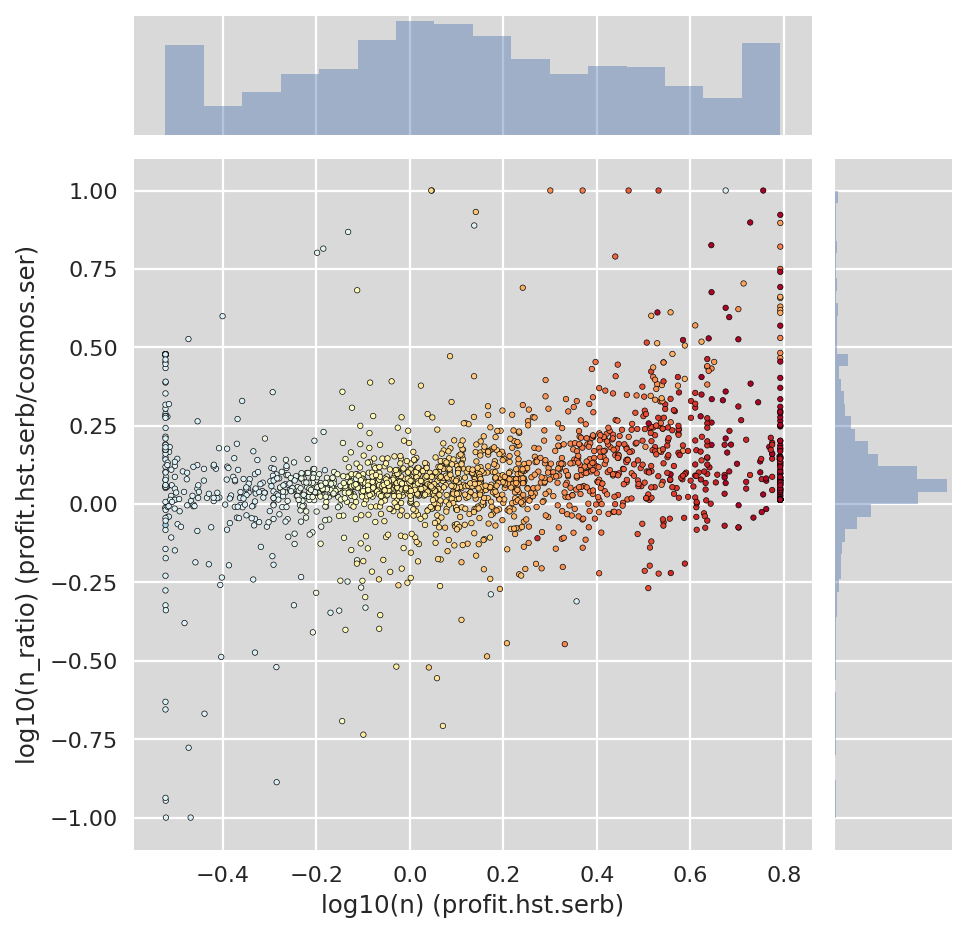

In [10]:
plotjoint(tab, "profit.hst.serb", "cosmos.ser", varnames)

### COSMOS-HST: MultiProFit Sersic vs MultiProFit MGA Sersic (N=8)

How close is the N=8 MGA to a true Sersic fit? The answer is quite close, except at n>4 where the MGA intentionally does not match the inner profile and for n < 0.5 where the MGA can't possibly match a true Sersic.

It seems like there are two different tracks of outliers: objects with n>4 where the MGA has some large but not unreasonable scatter, and objects with 2.5>n>4 where the MGA has systematically lower n (somewhat more mysterious).

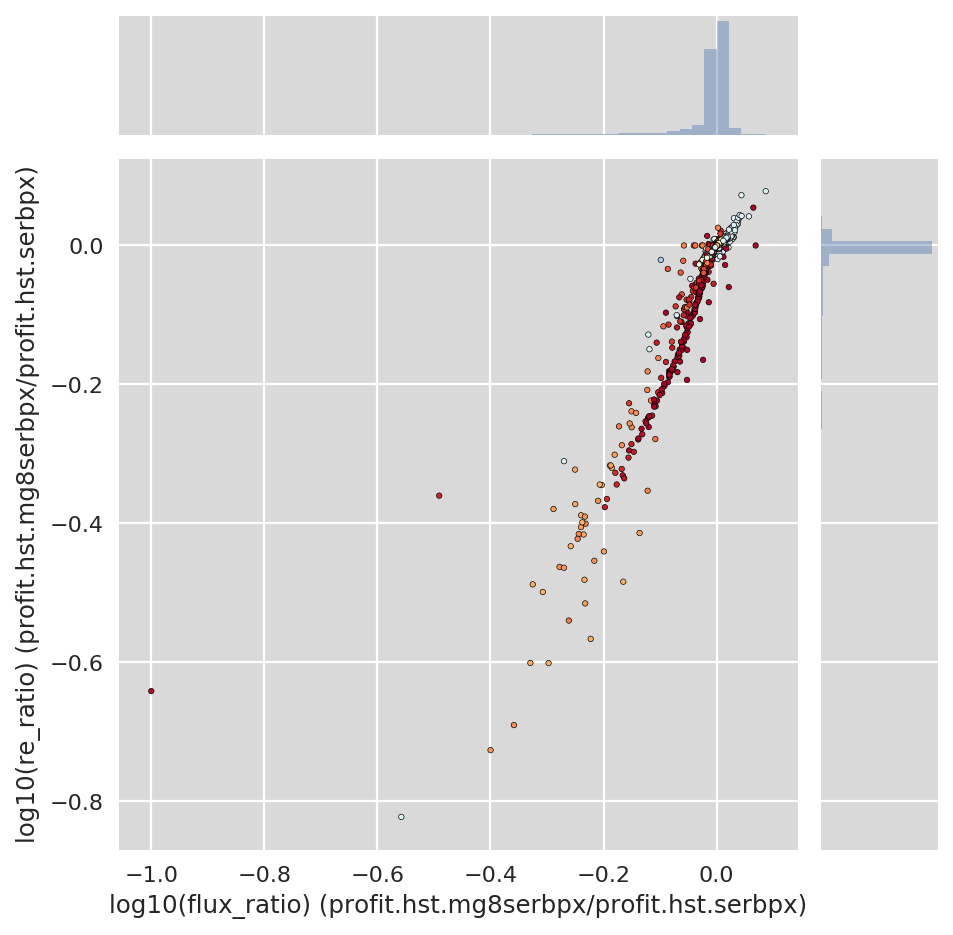

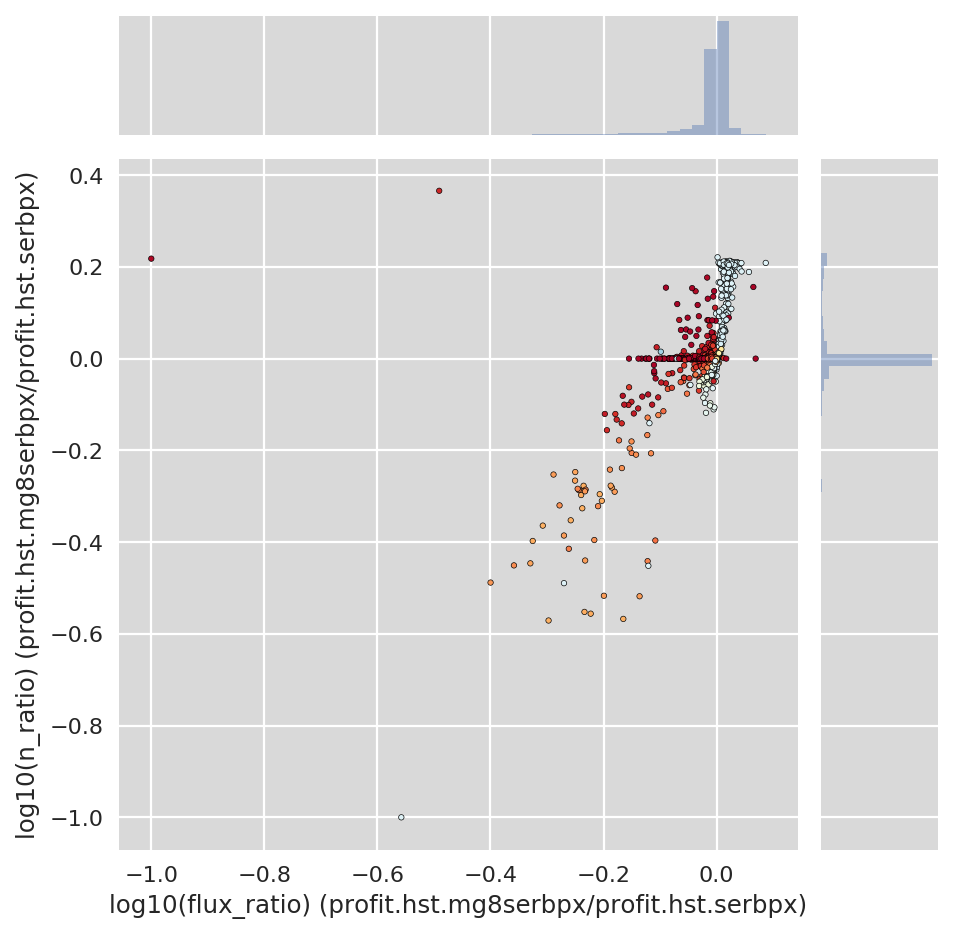

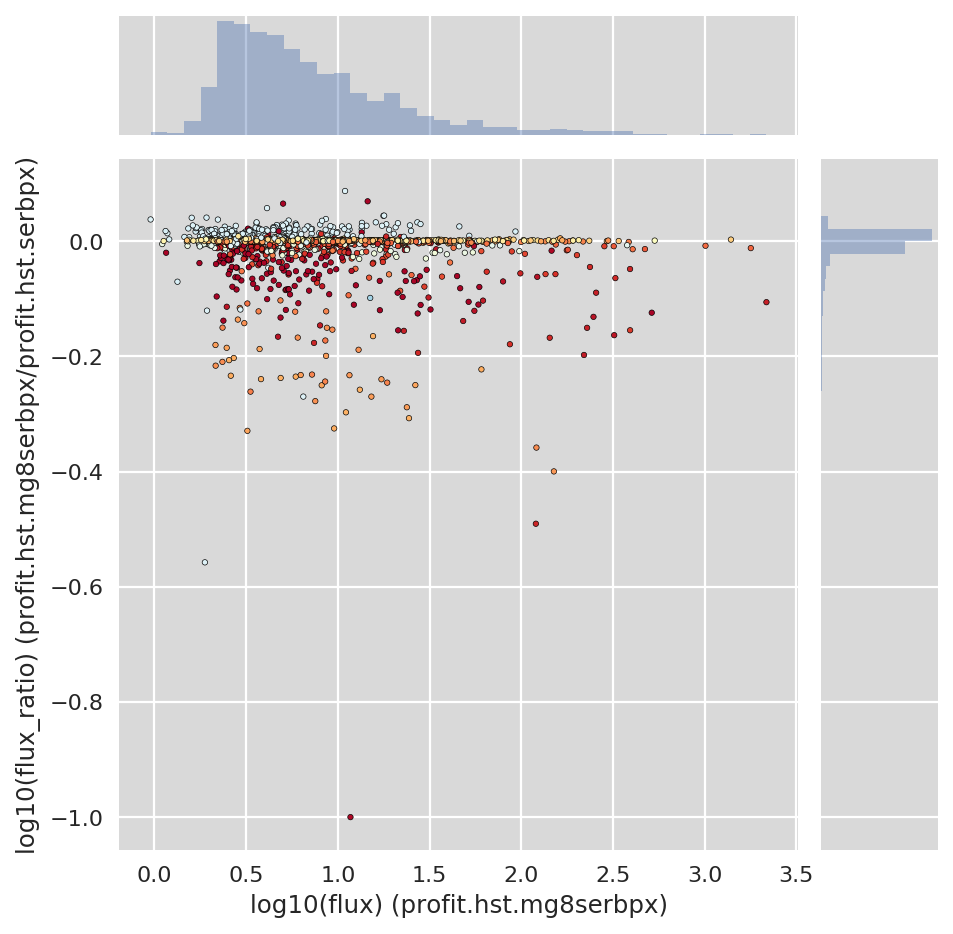

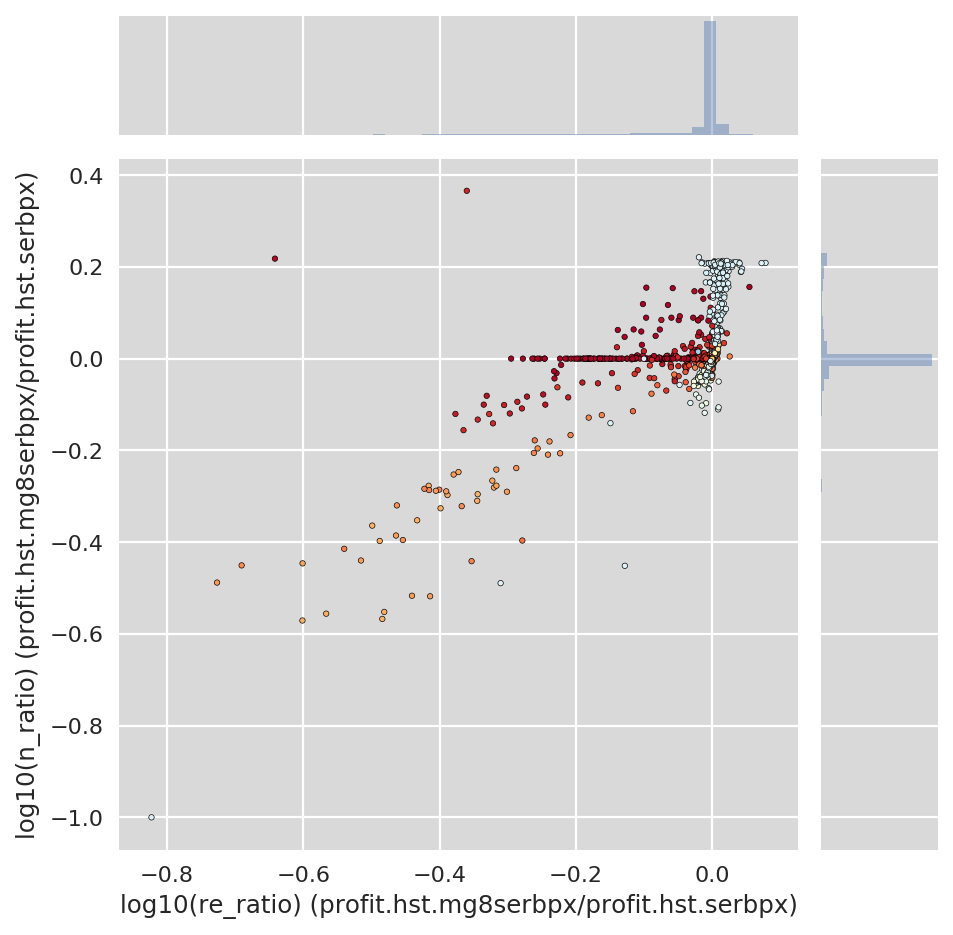

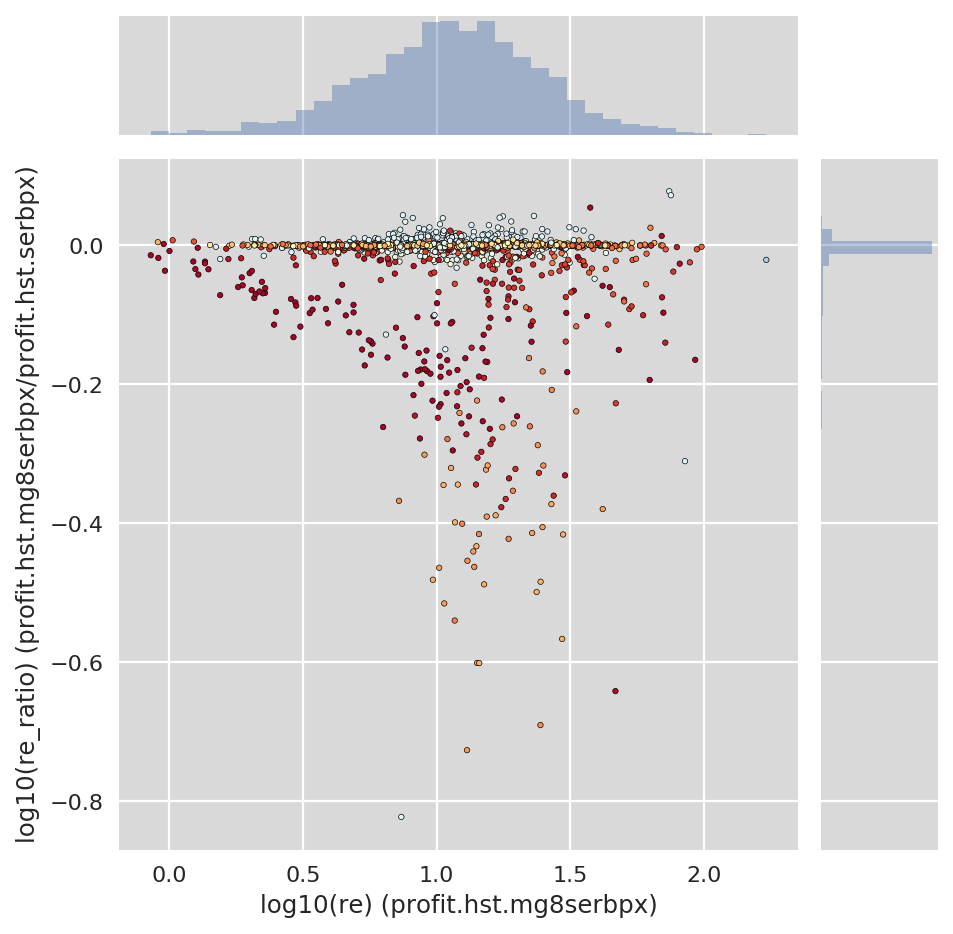

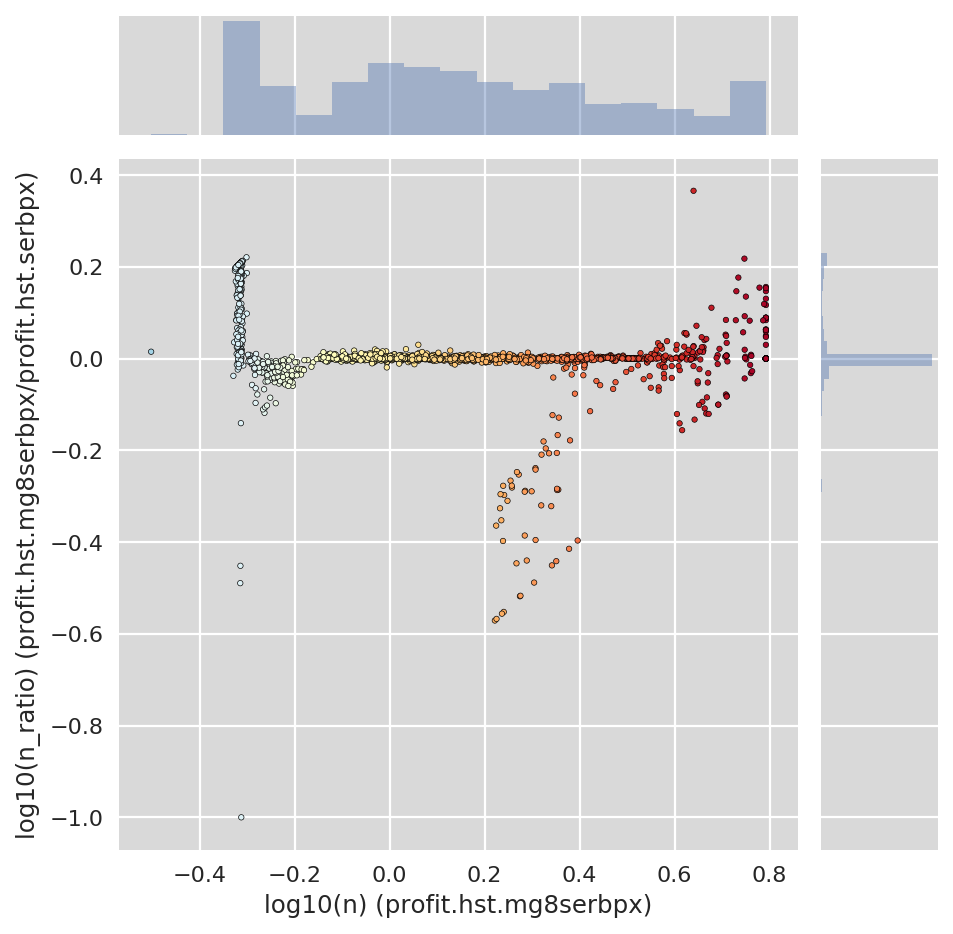

In [11]:
plotjoint(tab, "profit.hst.mg8serbpx", "profit.hst.serbpx", varnames)

### COSMOS-HST: MultiProFit Sersic vs MultiProFit MGA Sersic (N=4)

How close is the N=4 MGA to a true Sersic fit? Reasonably close, but there's clearly more scatter than with an N=8 fit, particularly at n>2 where more Gaussians are needed to match the shallow outer profile.

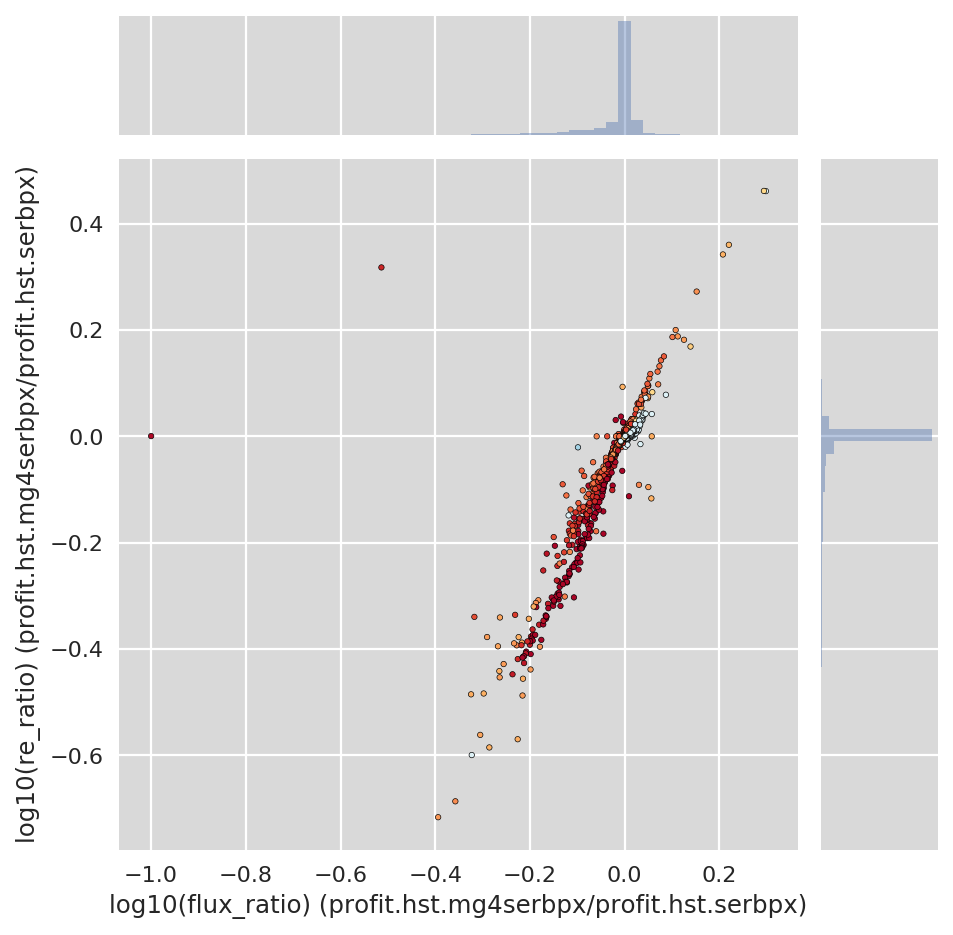

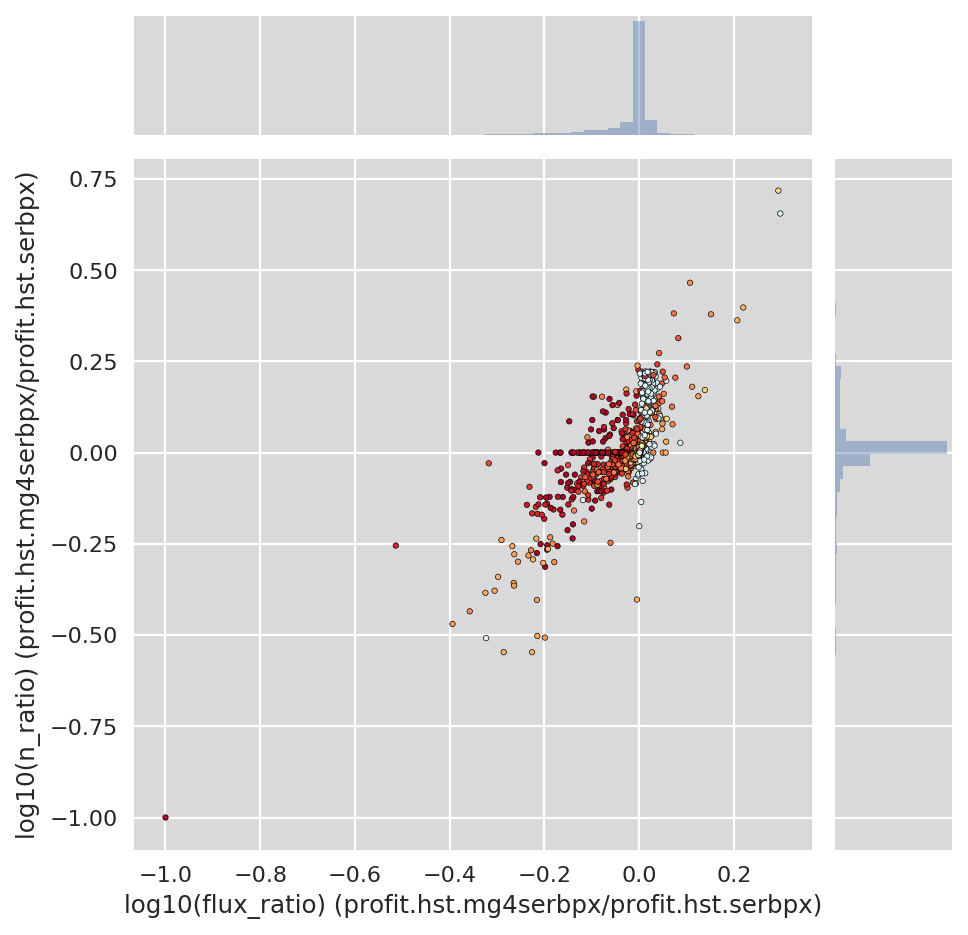

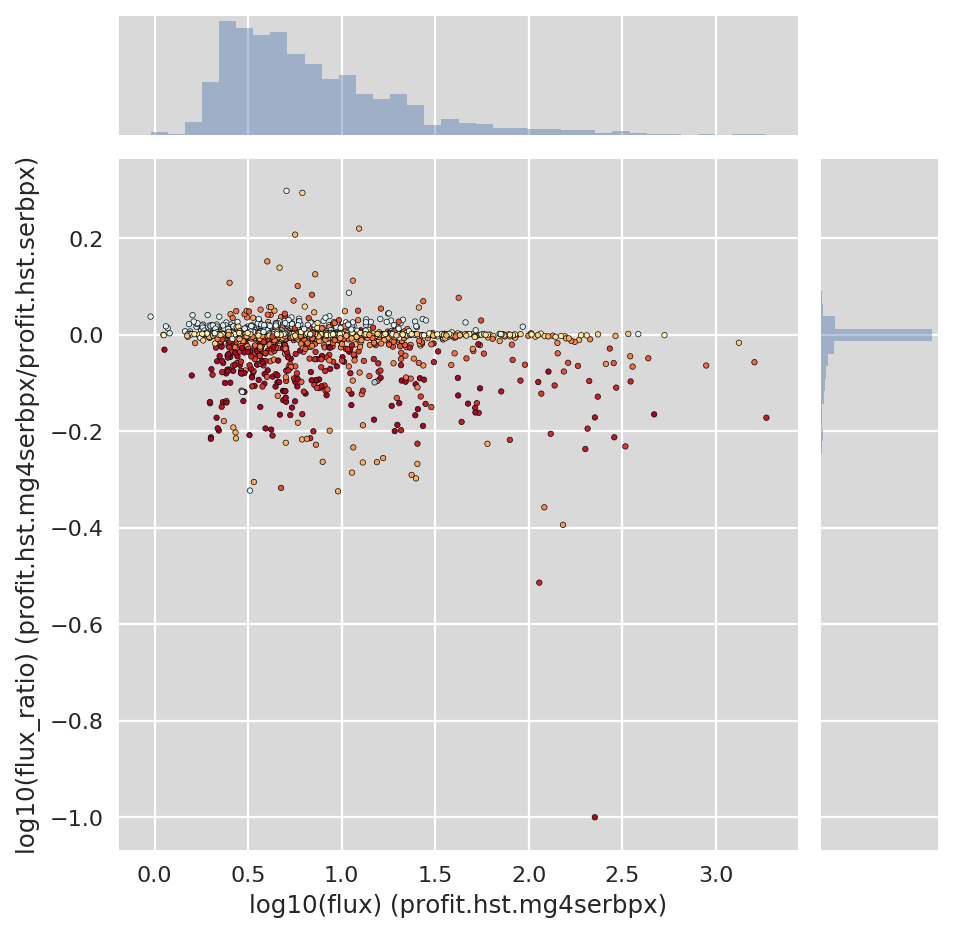

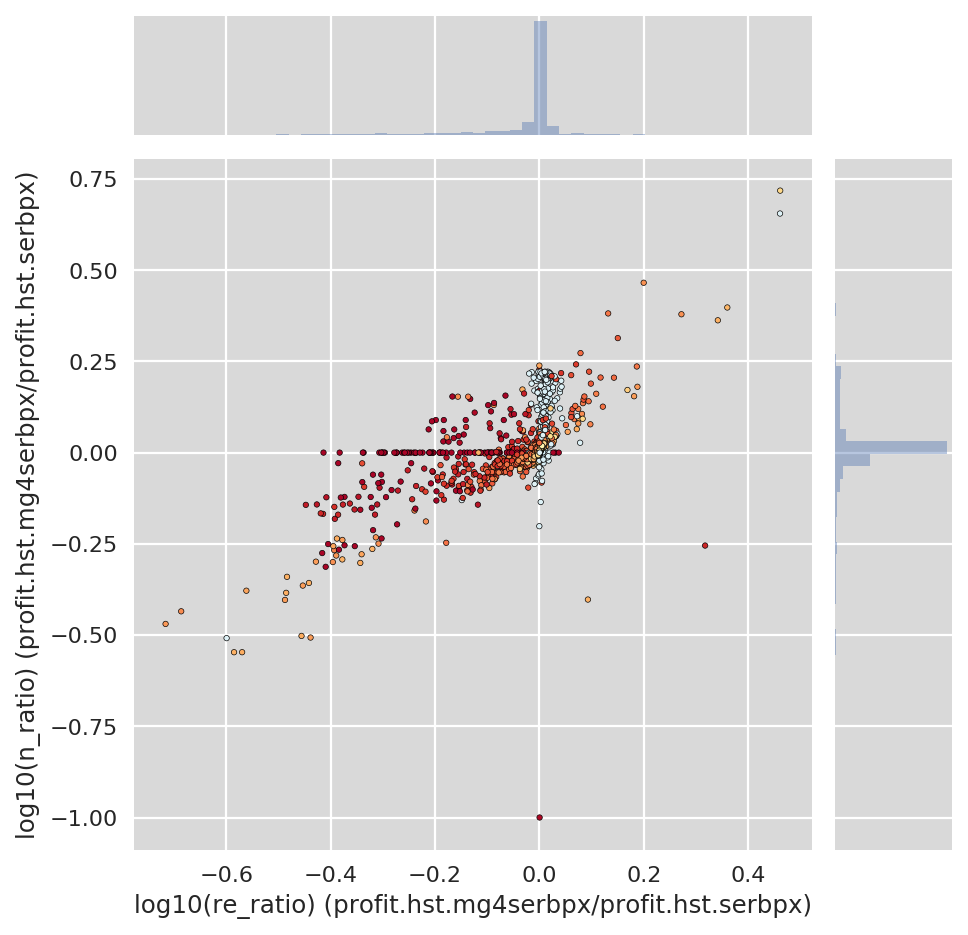

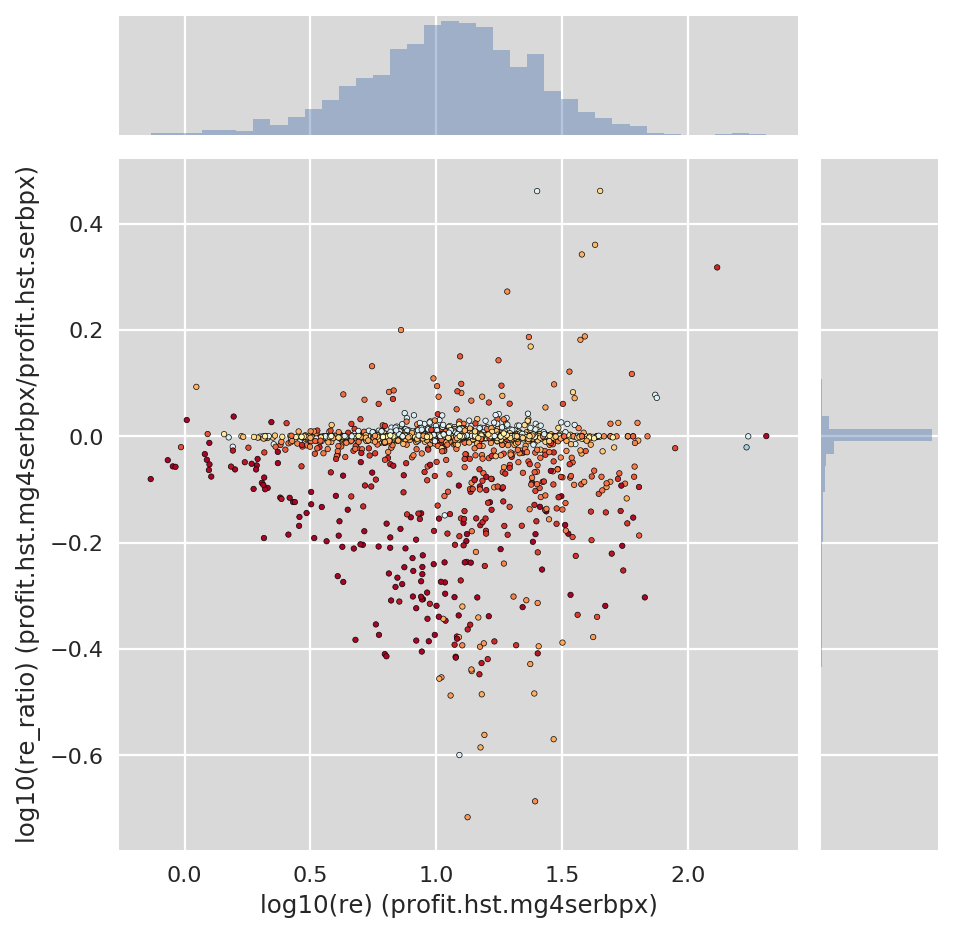

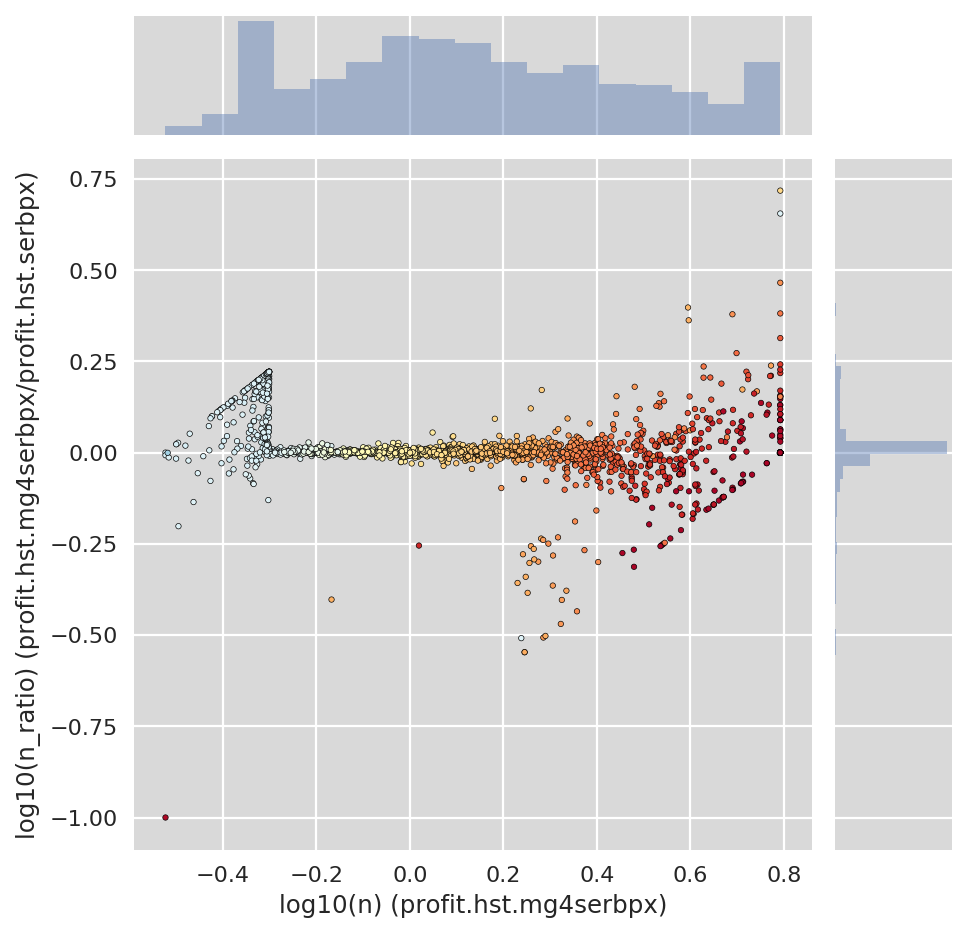

In [12]:
plotjoint(tab, "profit.hst.mg4serbpx", "profit.hst.serbpx", varnames)

### COSMOS-HST: MultiProFit MGA Sersic vs MultiProFit GMM (N=8)

How much different is a free GMM compared to a constrained Sersic MGA? The answer might surprise you. In fact there are non-negligible systematic differences. It may be expected that large-n galaxies tend to smaller fluxes and sizes with a full GMM, whereas the opposite is true for low-n galaxies.

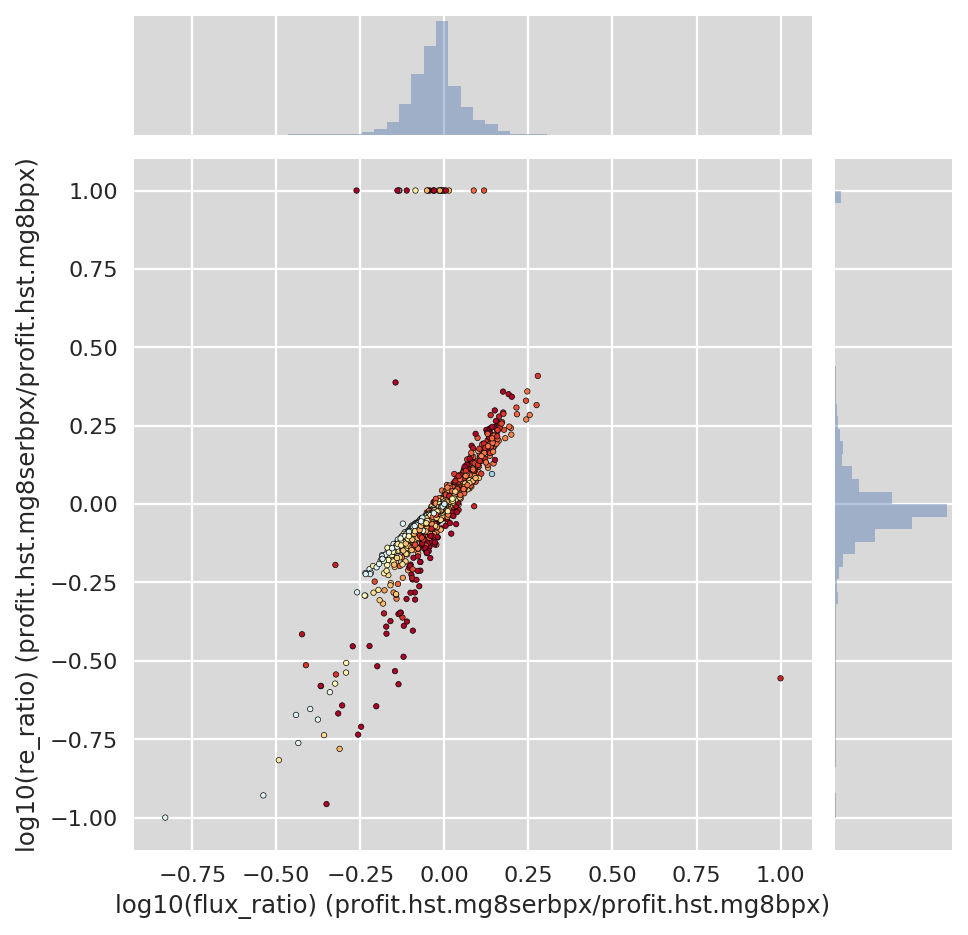

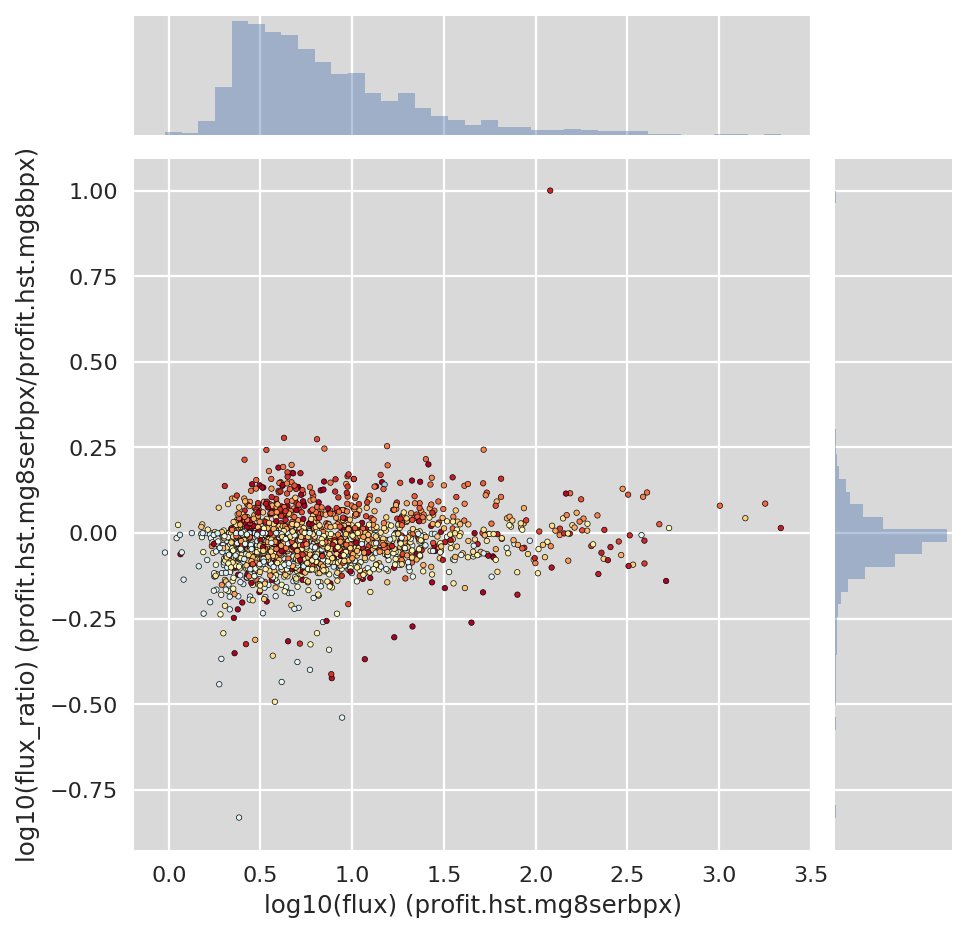

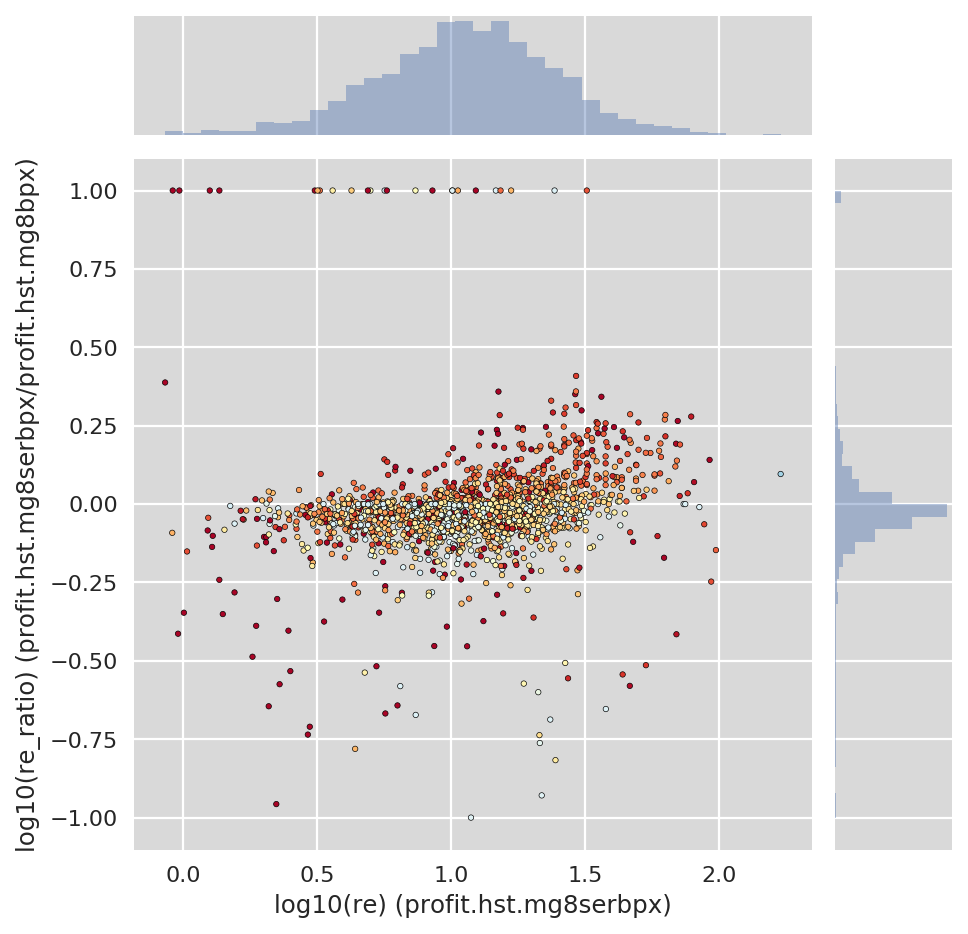

In [13]:
plotjoint(tab, "profit.hst.mg8serbpx", "profit.hst.mg8bpx", ["flux", "re"])

### COSMOS-HST: MultiProFit MGA Sersic vs MultiProFit GMM (N=4)

As above, but different?

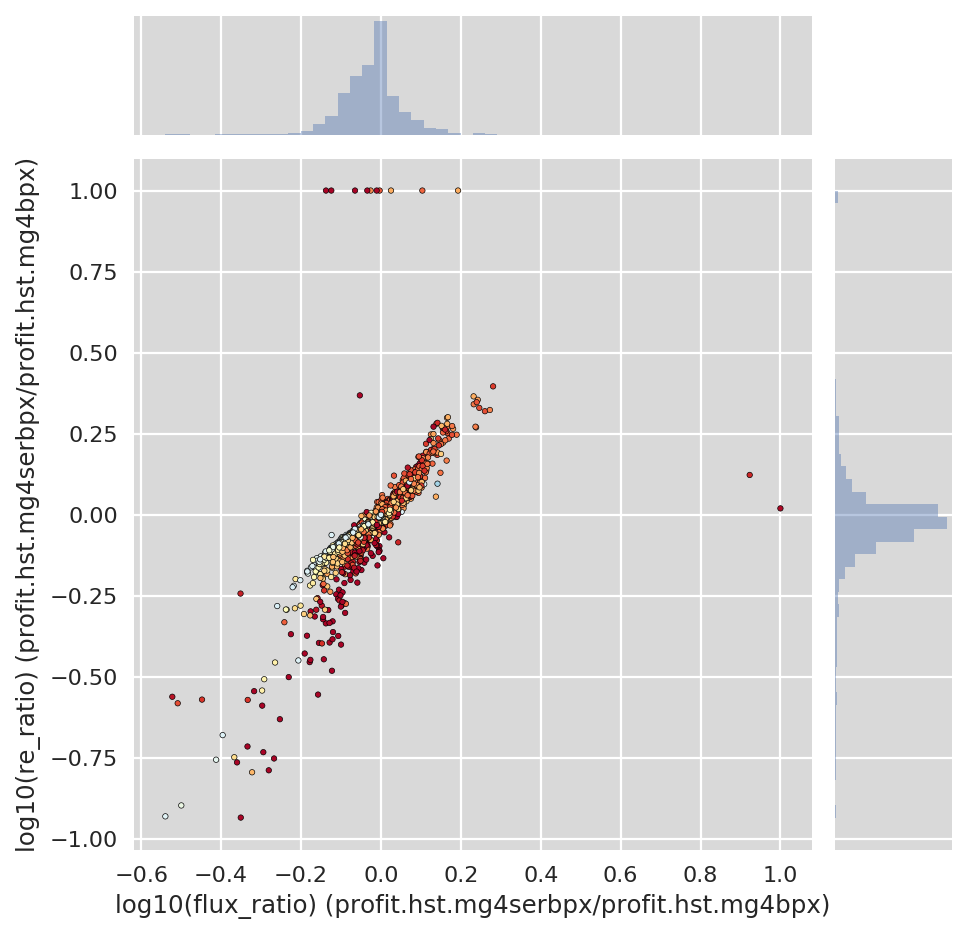

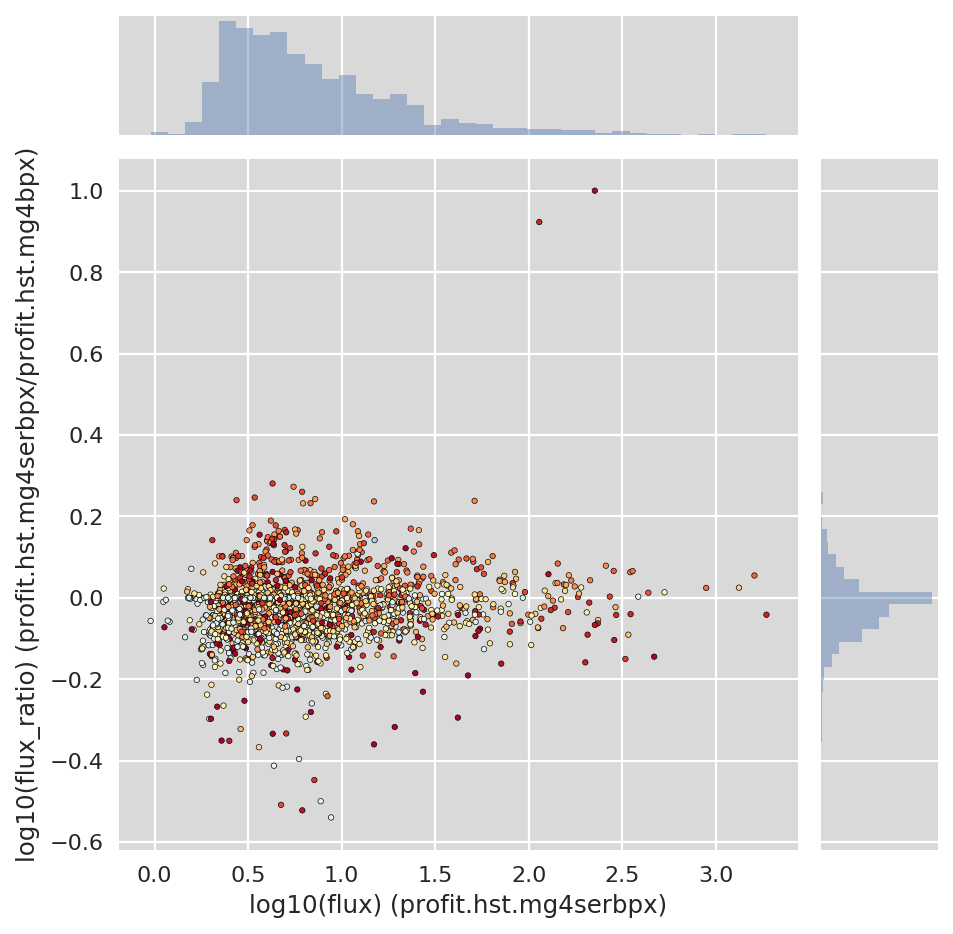

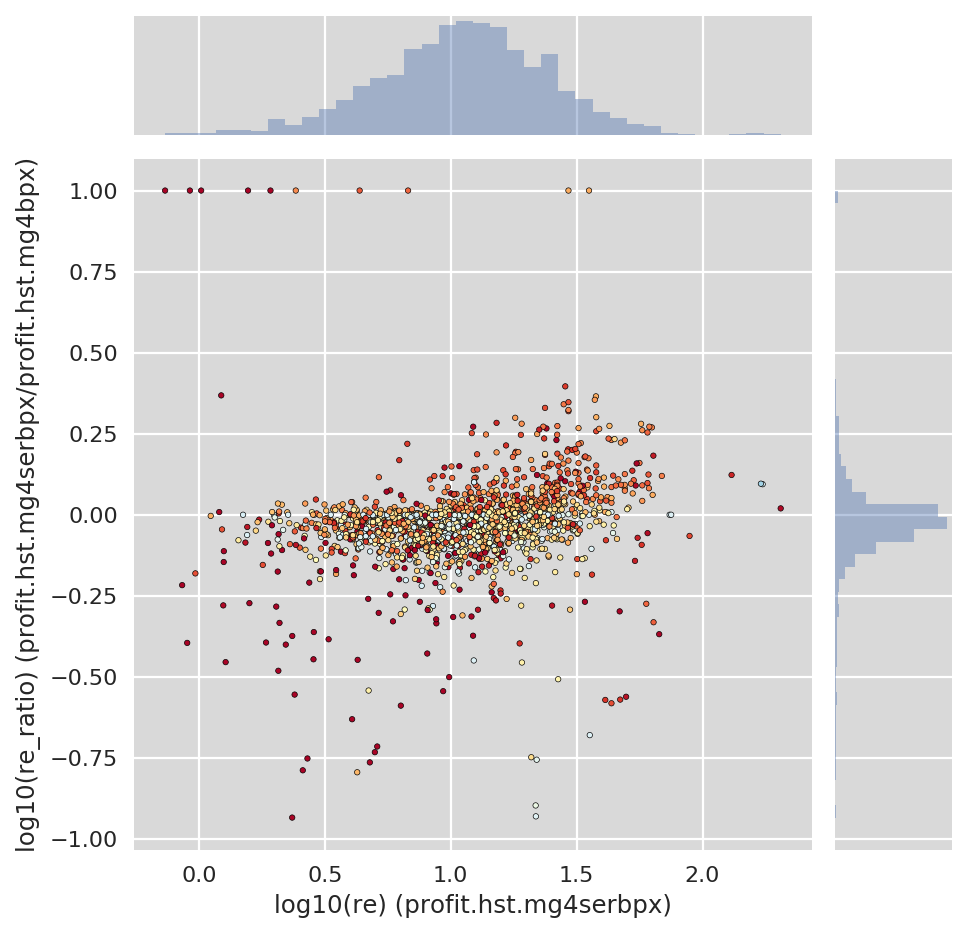

In [14]:
plotjoint(tab, "profit.hst.mg4serbpx", "profit.hst.mg4bpx", ["flux", "re"])

### MultiProFit MGA Sersic: COSMOS-HST vs COSMOS-HSC

How well does a fit to Subaru-HSC data recover the parameters derived from the HST fits? It should do well modulo noise bias, because I generated an image of the true model but used the observed variance to give it noise.

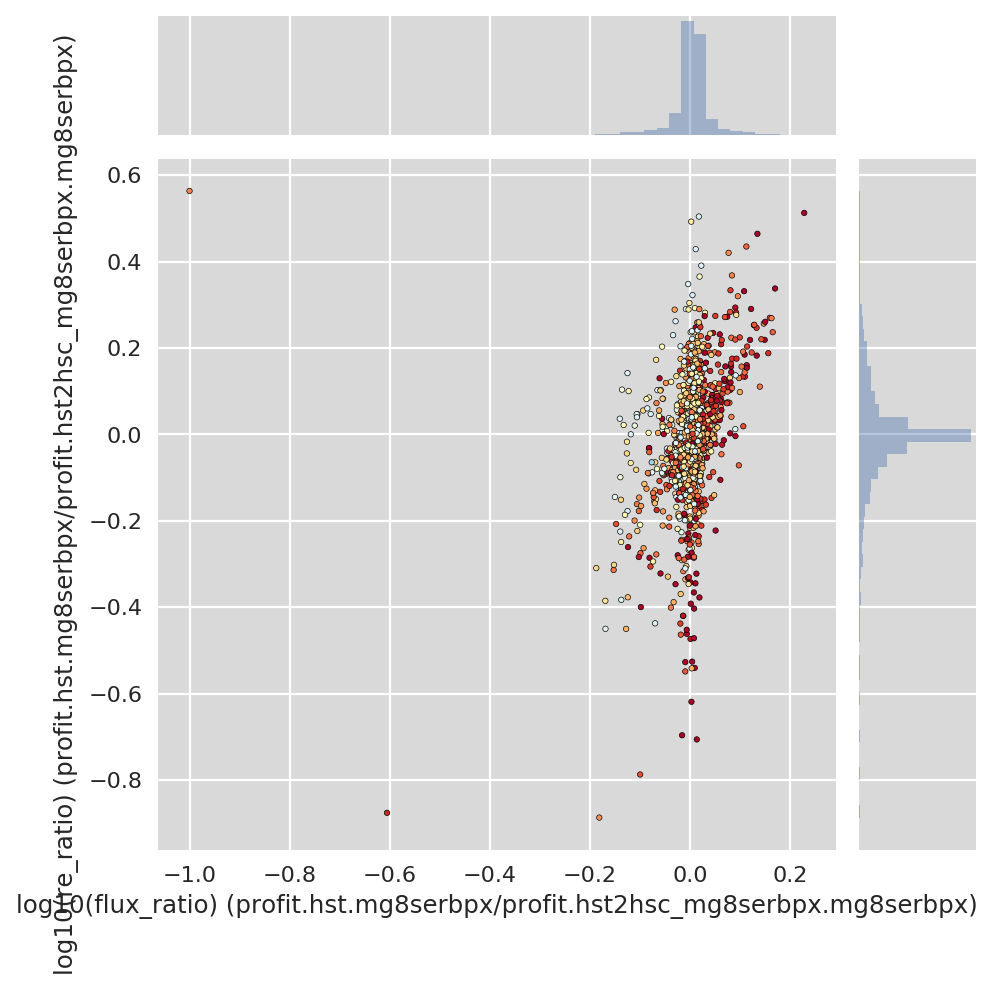

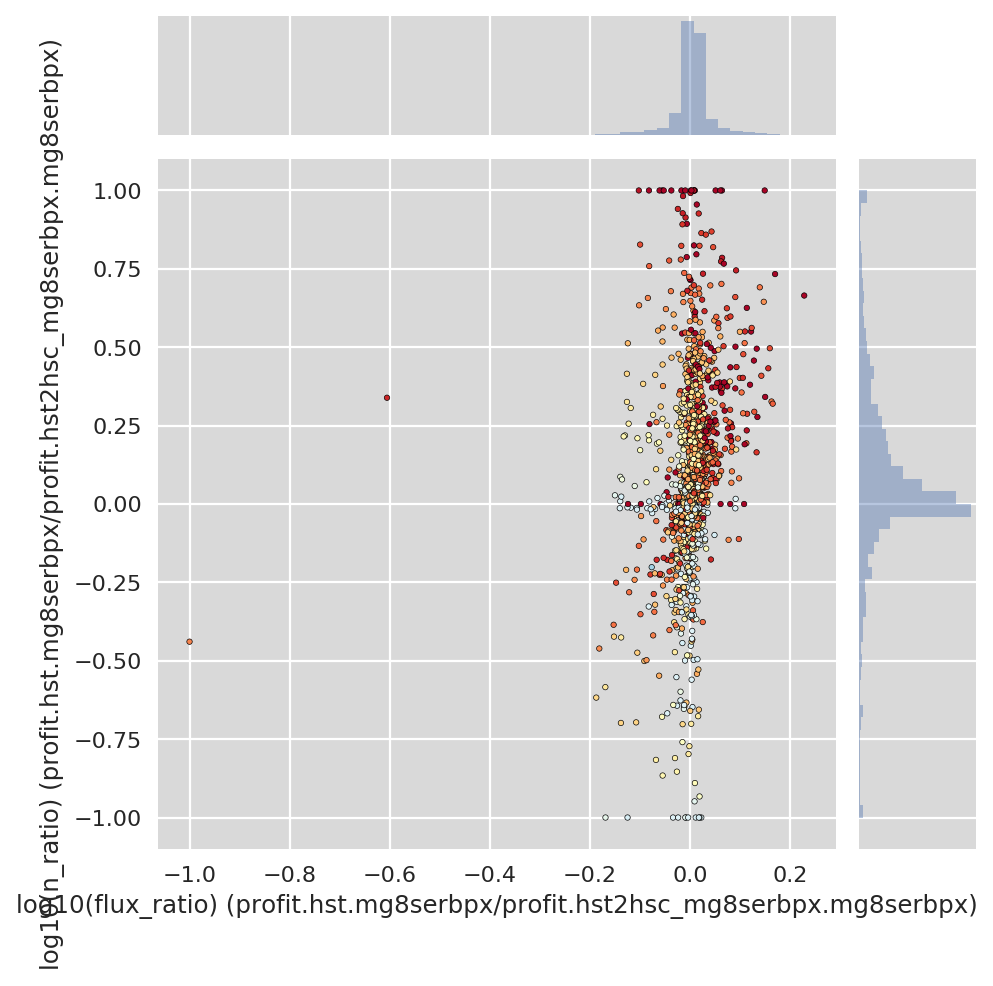

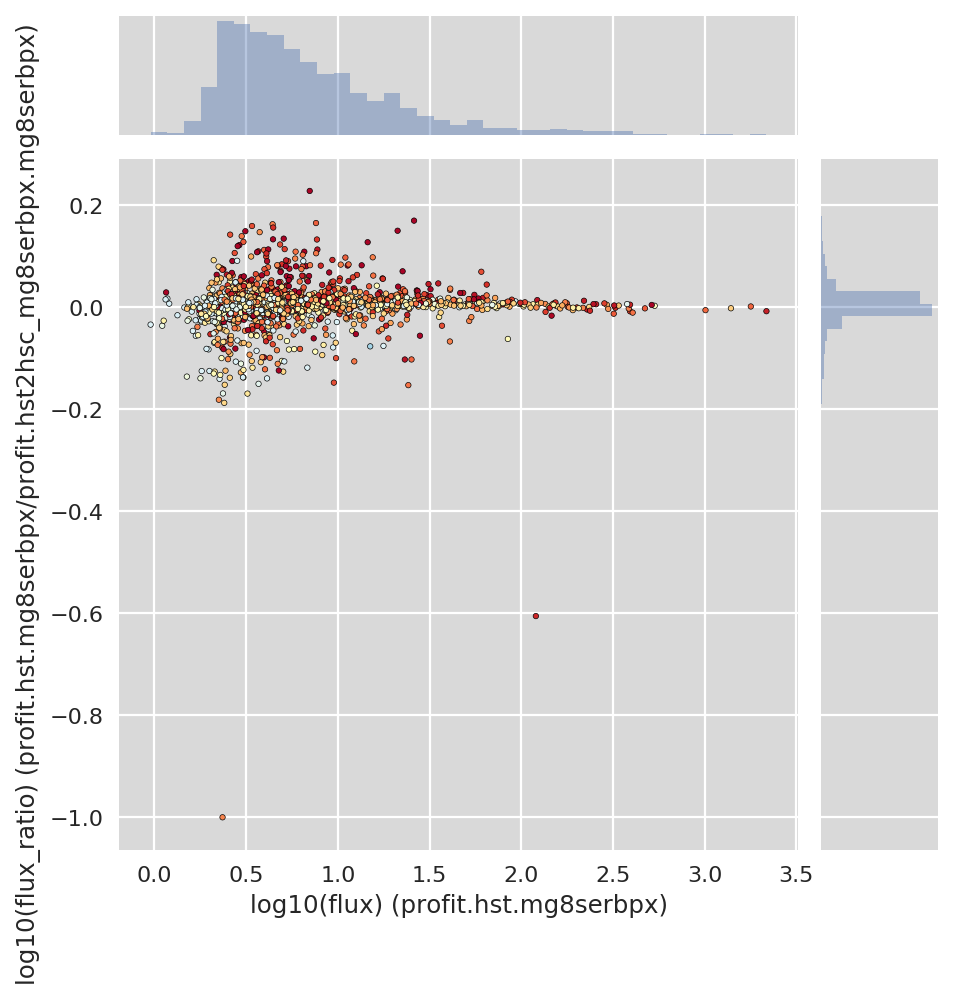

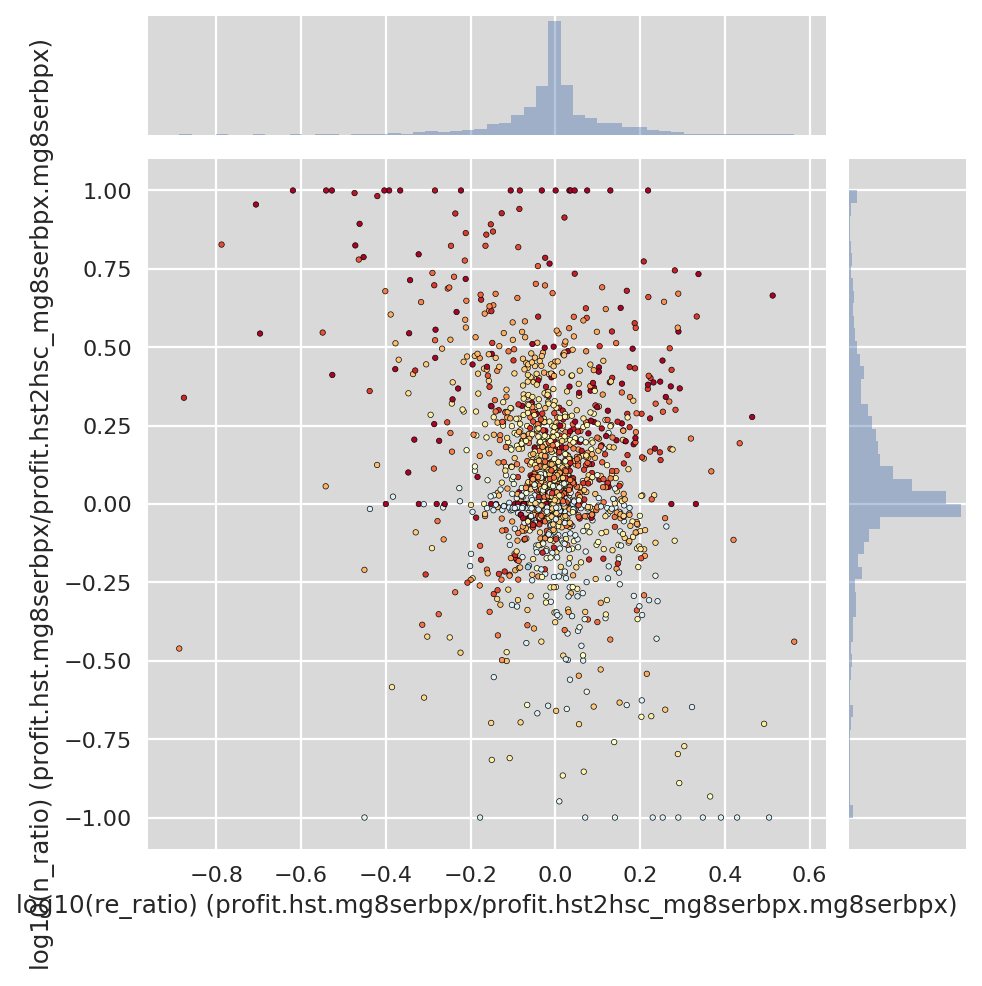

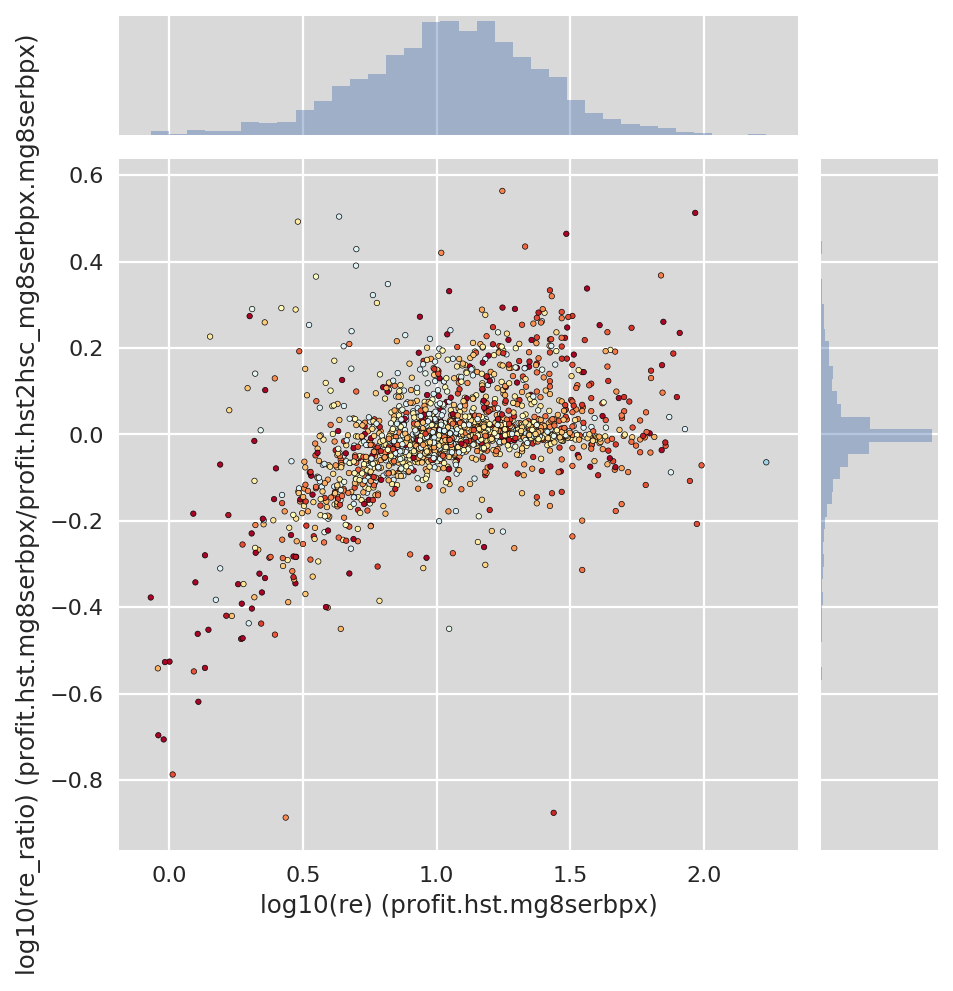

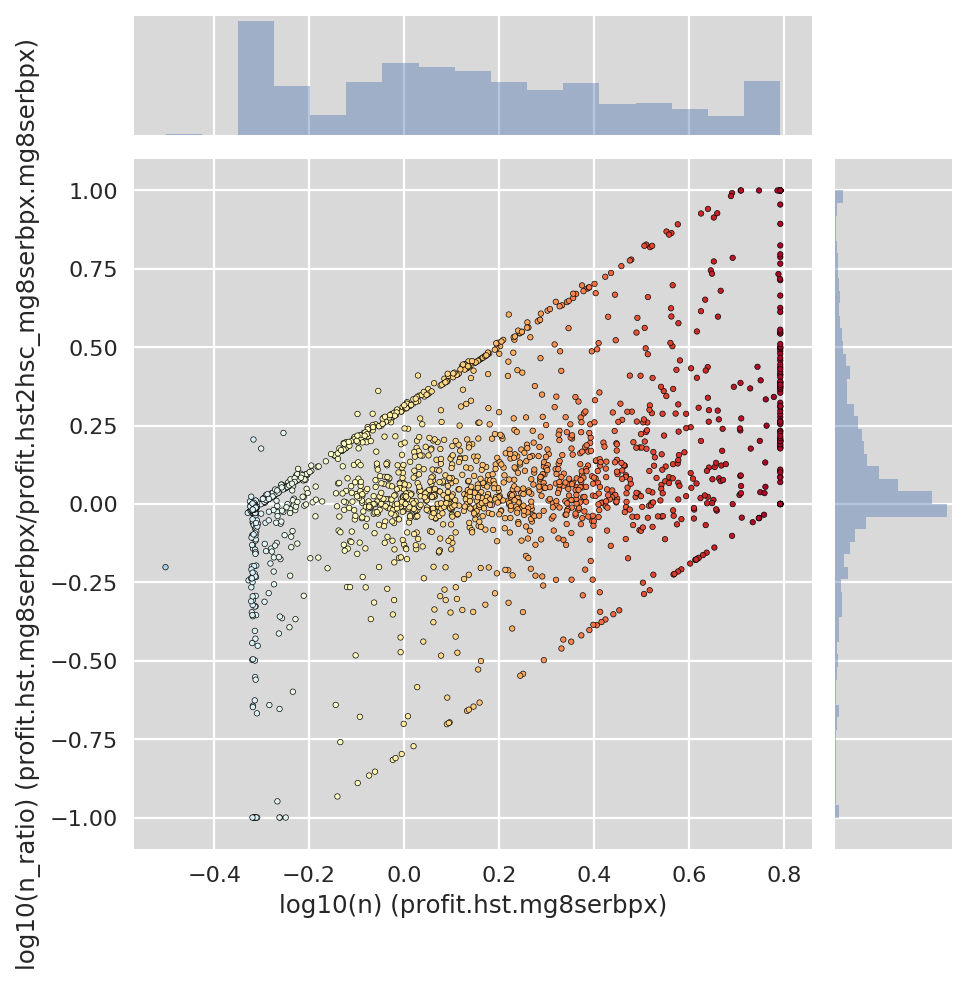

In [15]:
plotjoint(tab, "profit.hst.mg8serbpx", "profit.hst2hsc_mg8serbpx.mg8serbpx", varnames)

### Model comparison plots

These plots compare the goodness of fit (reduced chi-squared in this case) of different model combinations. This mainly helps to determine which models are worth fitting and - judging by the absolute goodness of fit and the best-fit Sersic index for the single MG Sersic - what kind of galaxies each model is good for.

The first plot is probably the most interesting, as it shows that a single Sersic fit is better for most galaxies with a best-fit Sersic index n~0.5 or n~6 than a more complicated DevExp model, whereas the devExp model appears to do better for more typical galaxies with intermediate values of 1 < n < 4. We also see that most of the galaxies for which a low-n single Sersic fit is preferred (light blue dots below 0 on the y-axis) tend to have relatively low reduced chi-squared values; these galaxies are probably not very well resolved and the fact that the devExp fit is usually not much worse suggests that they're most likely not truly Gaussian-like profiles. On the other hand, there are a significant number of galaxies preferring high-n Sersic fits to devExp; it's possible that some of these really are extended elliptical galaxies rather than bulge+disk systems.

Some of the later plots compare equivalent models where the only differences are the initial parameters; an ideal optimizer should reach identical solutions for both.

{'gausspx': 'profit.hst.gausspx.chisqred.0', 'mg8exppx': 'profit.hst.mg8exppx.chisqred.0', 'mg8n2px': 'profit.hst.mg8n2px.chisqred.0', 'mg8dev2px': 'profit.hst.mg8dev2px.chisqred.0', 'mg8serbpx': 'profit.hst.mg8serbpx.chisqred.0', 'mg8serbedpx': 'profit.hst.mg8serbedpx.chisqred.0', 'mg4exppx': 'profit.hst.mg4exppx.chisqred.0', 'mg4n2px': 'profit.hst.mg4n2px.chisqred.0', 'mg4dev2px': 'profit.hst.mg4dev2px.chisqred.0', 'mg4serbpx': 'profit.hst.mg4serbpx.chisqred.0', 'mg4serbedpx': 'profit.hst.mg4serbedpx.chisqred.0', 'mg8cmodelpx': 'profit.hst.mg8cmodelpx.chisqred.1', 'mg8devexppx': 'profit.hst.mg8devexppx.chisqred.1', 'mg8devexpcpx': 'profit.hst.mg8devexpcpx.chisqred.1', 'mg4cmodelpx': 'profit.hst.mg4cmodelpx.chisqred.1', 'mg4devexppx': 'profit.hst.mg4devexppx.chisqred.1', 'mg4devexpcpx': 'profit.hst.mg4devexpcpx.chisqred.1'}
profit.hst.mg8serbpx.chisqred.0       452
profit.hst.mg4devexppx.chisqred.1     396
profit.hst.mg4devexpcpx.chisqred.1    345
profit.hst.mg8devexppx.chisqred.1    

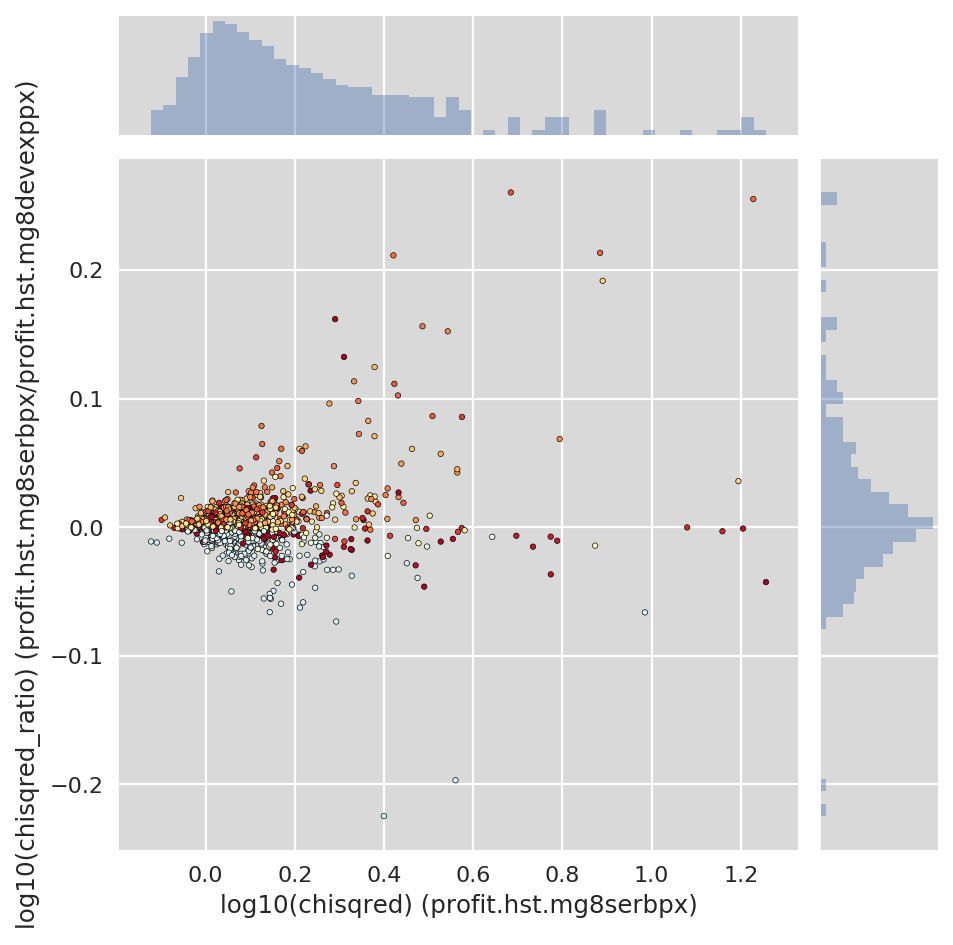

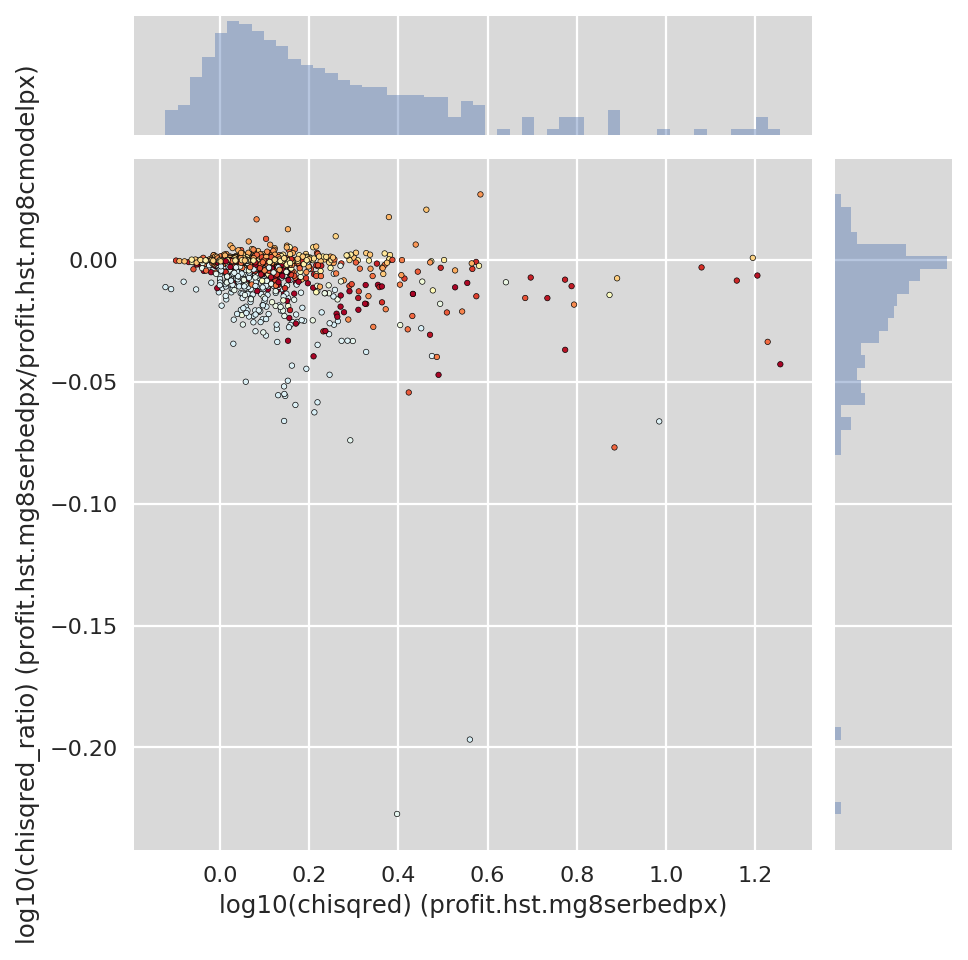

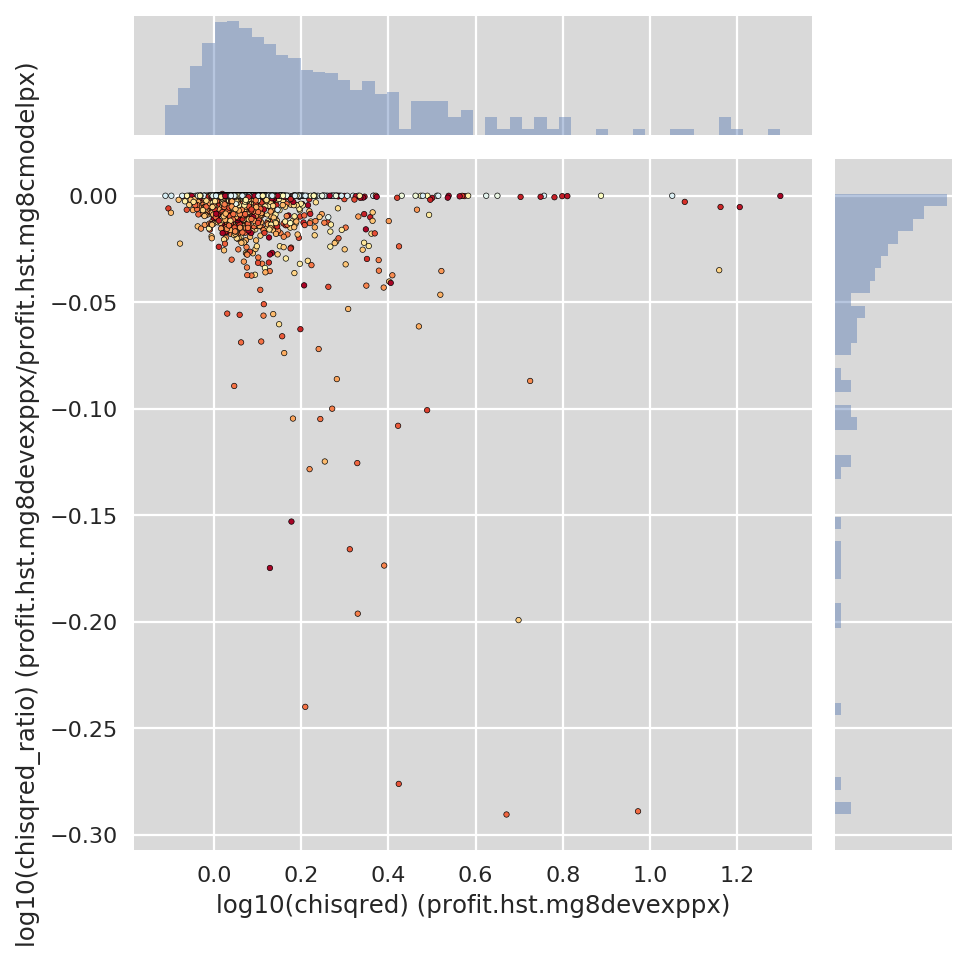

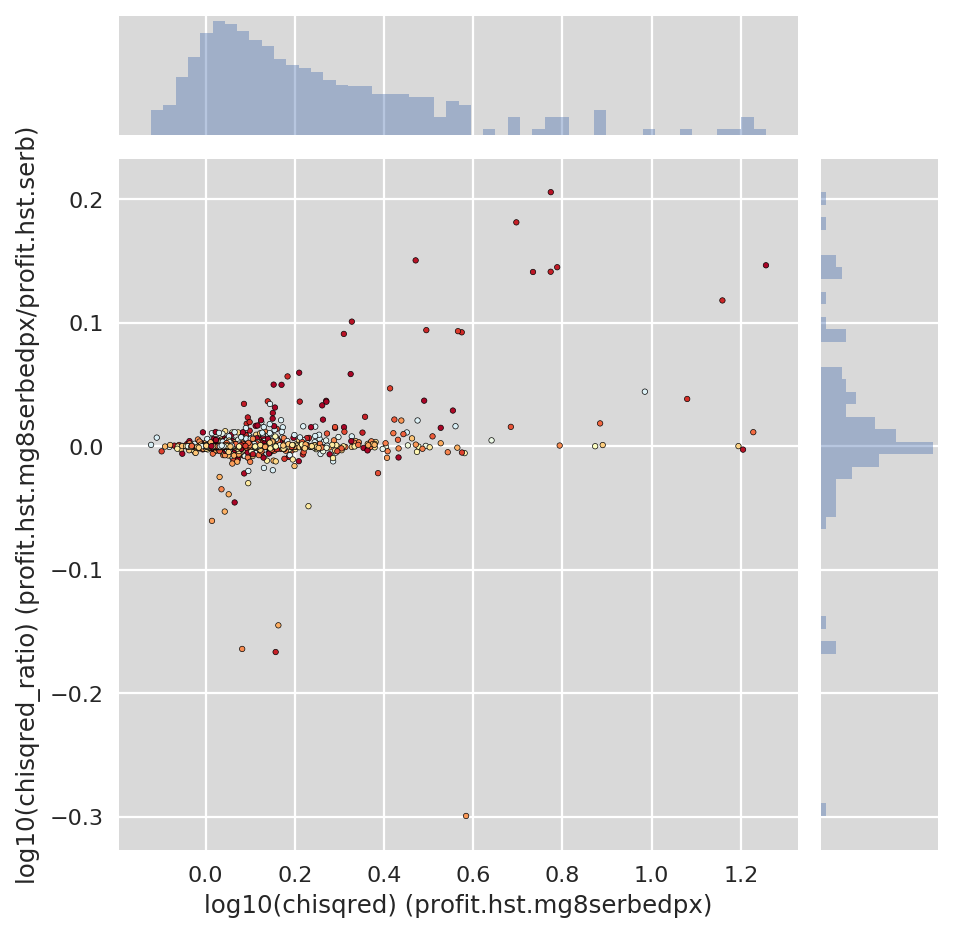

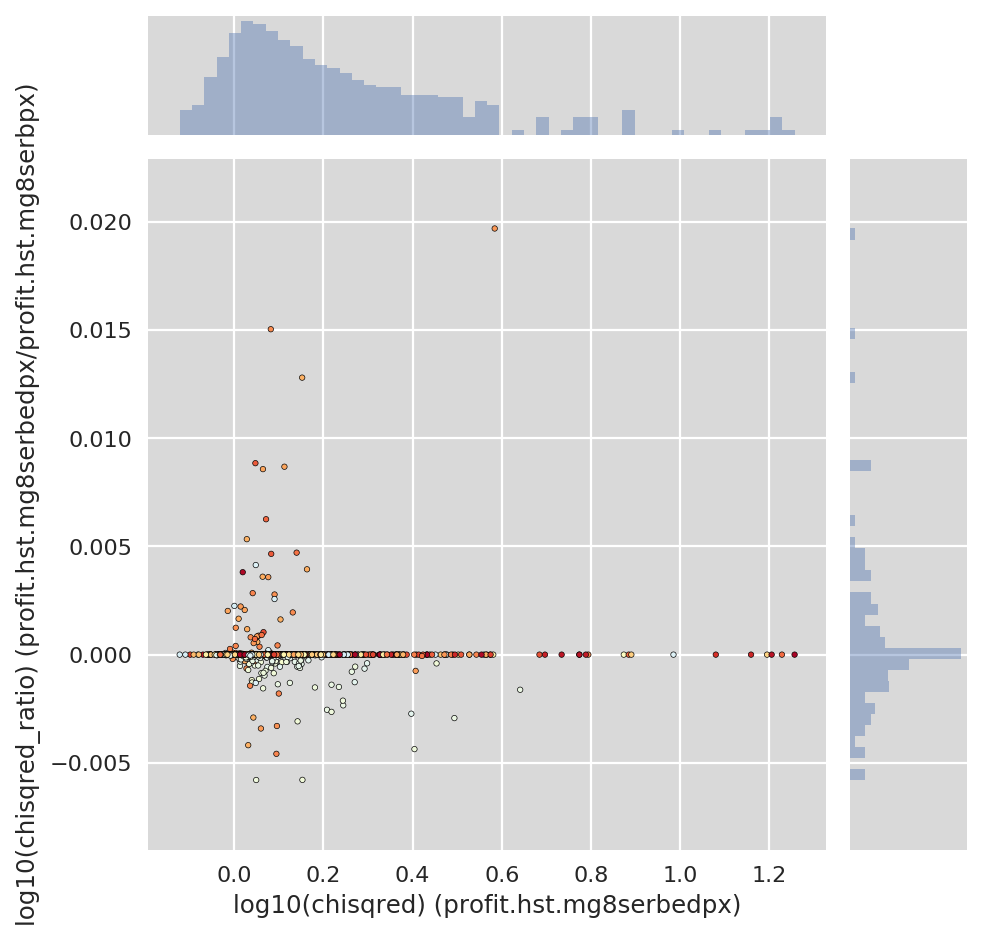

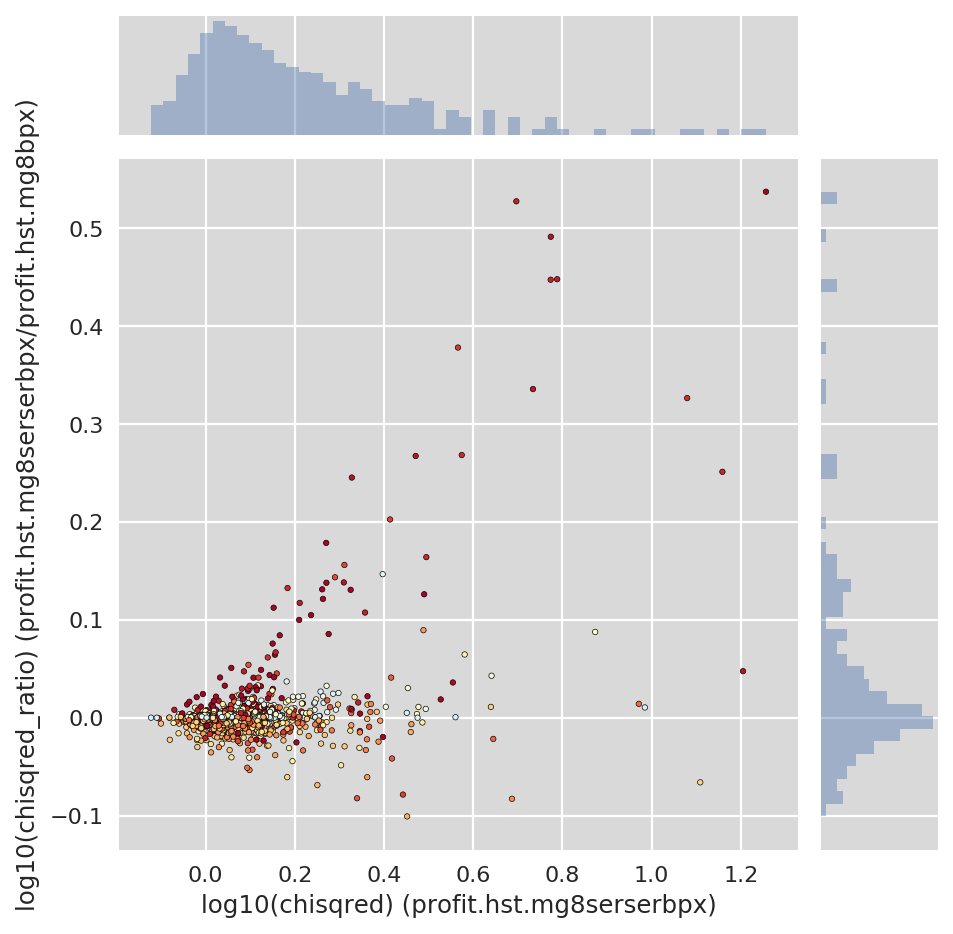

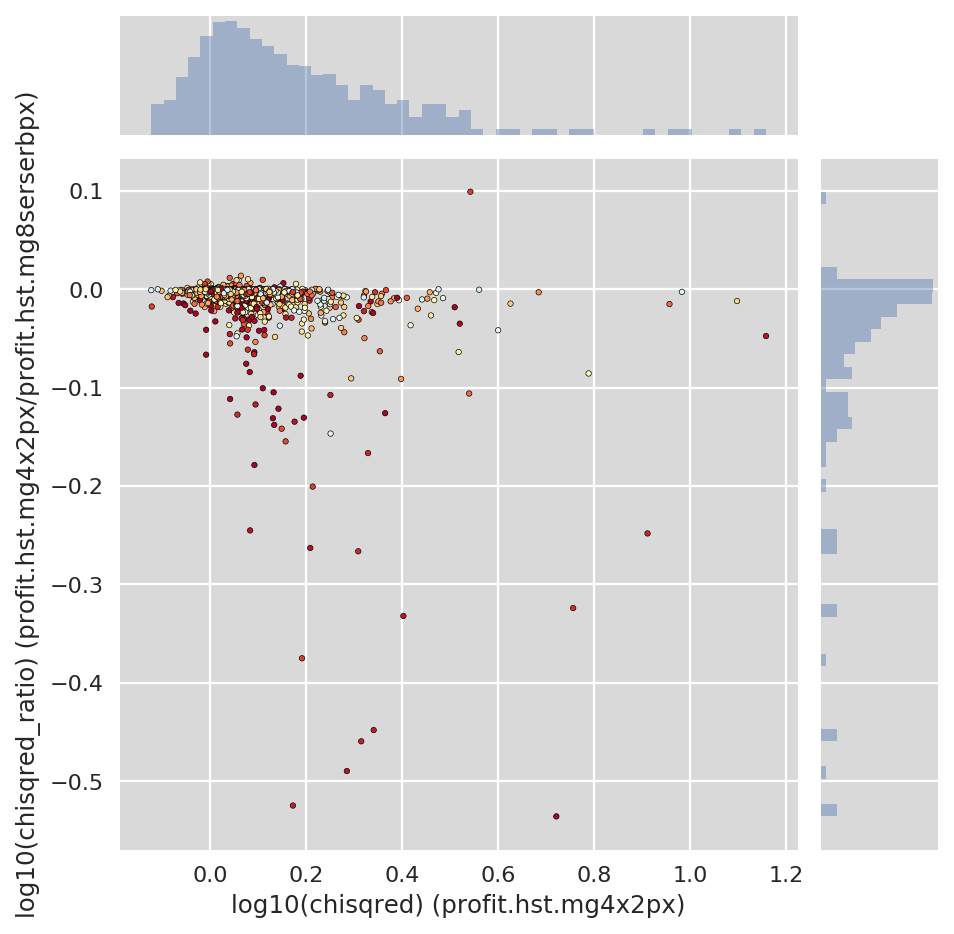

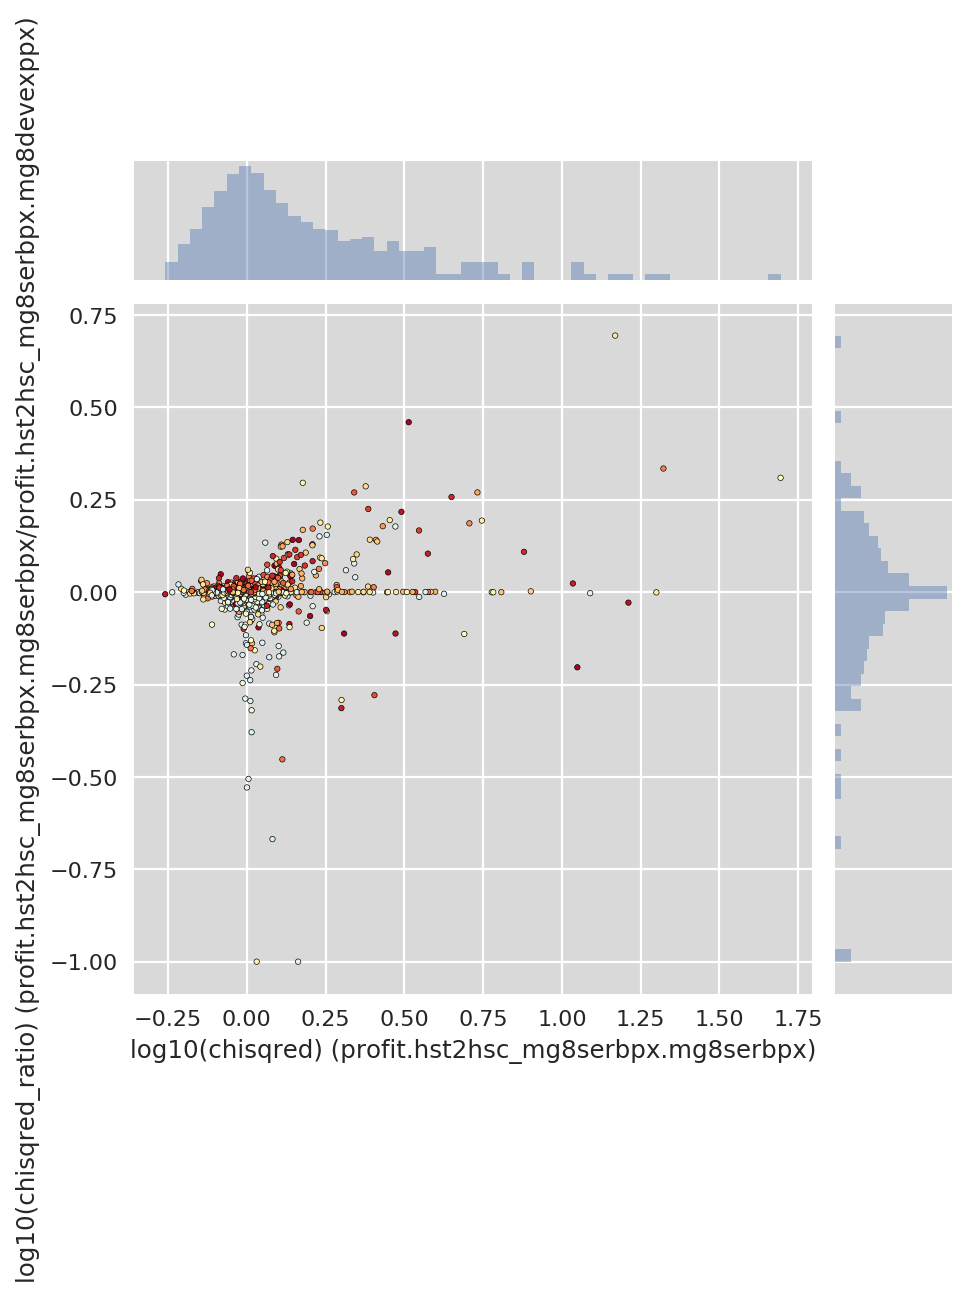

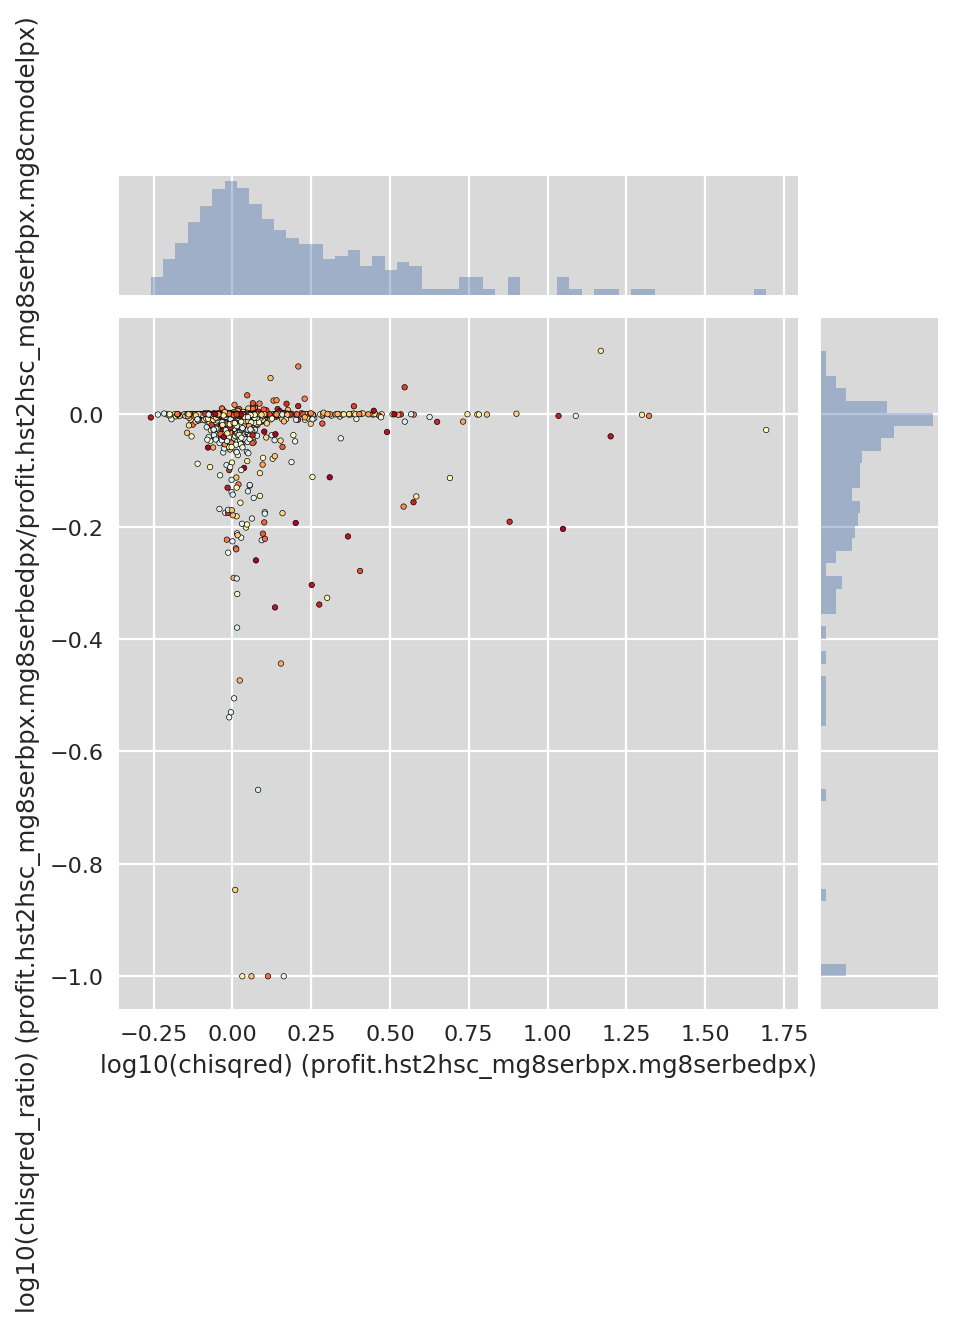

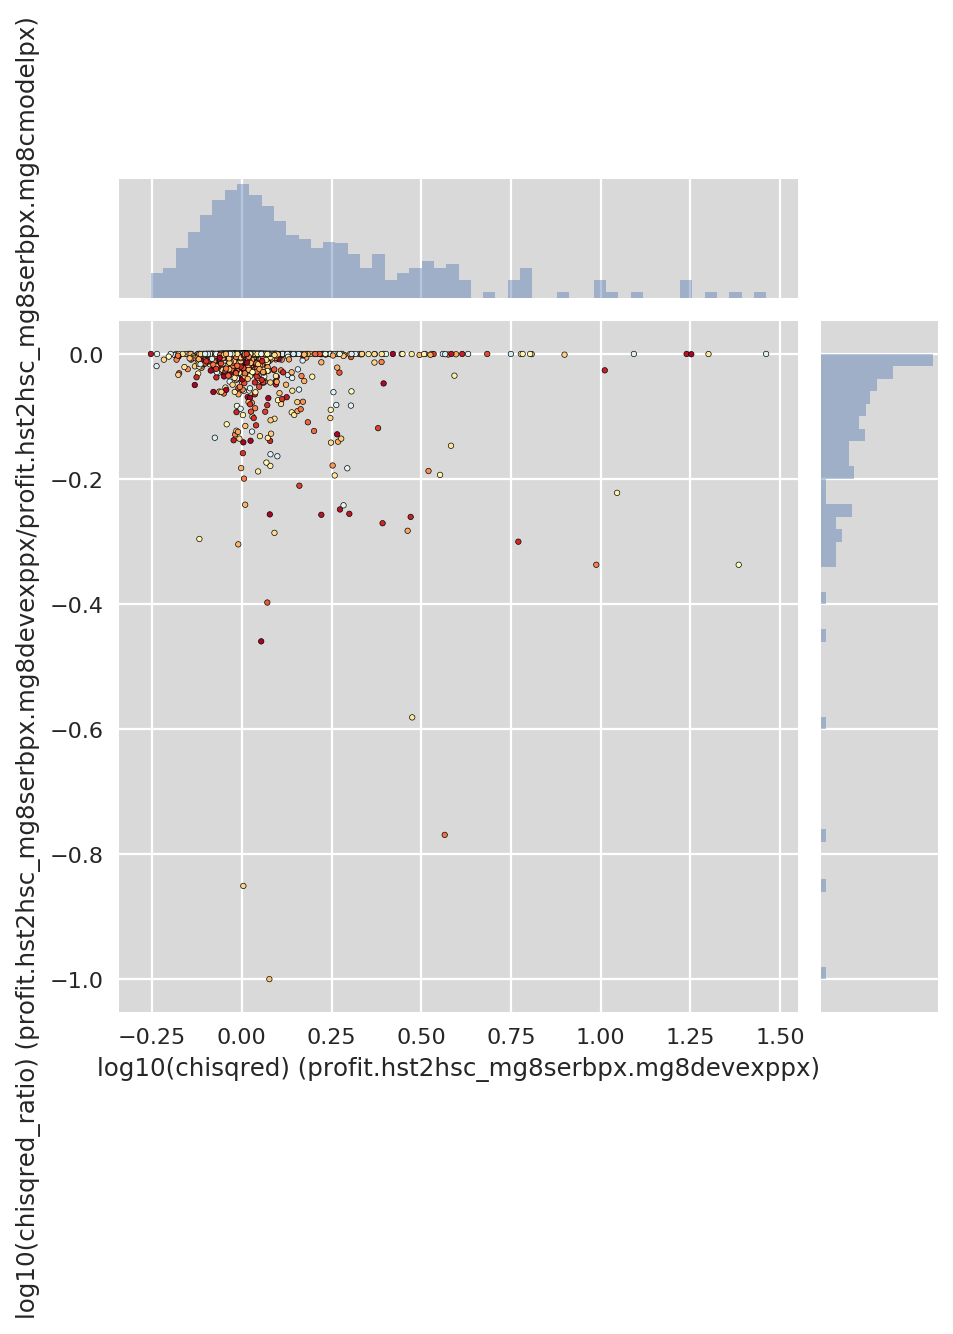

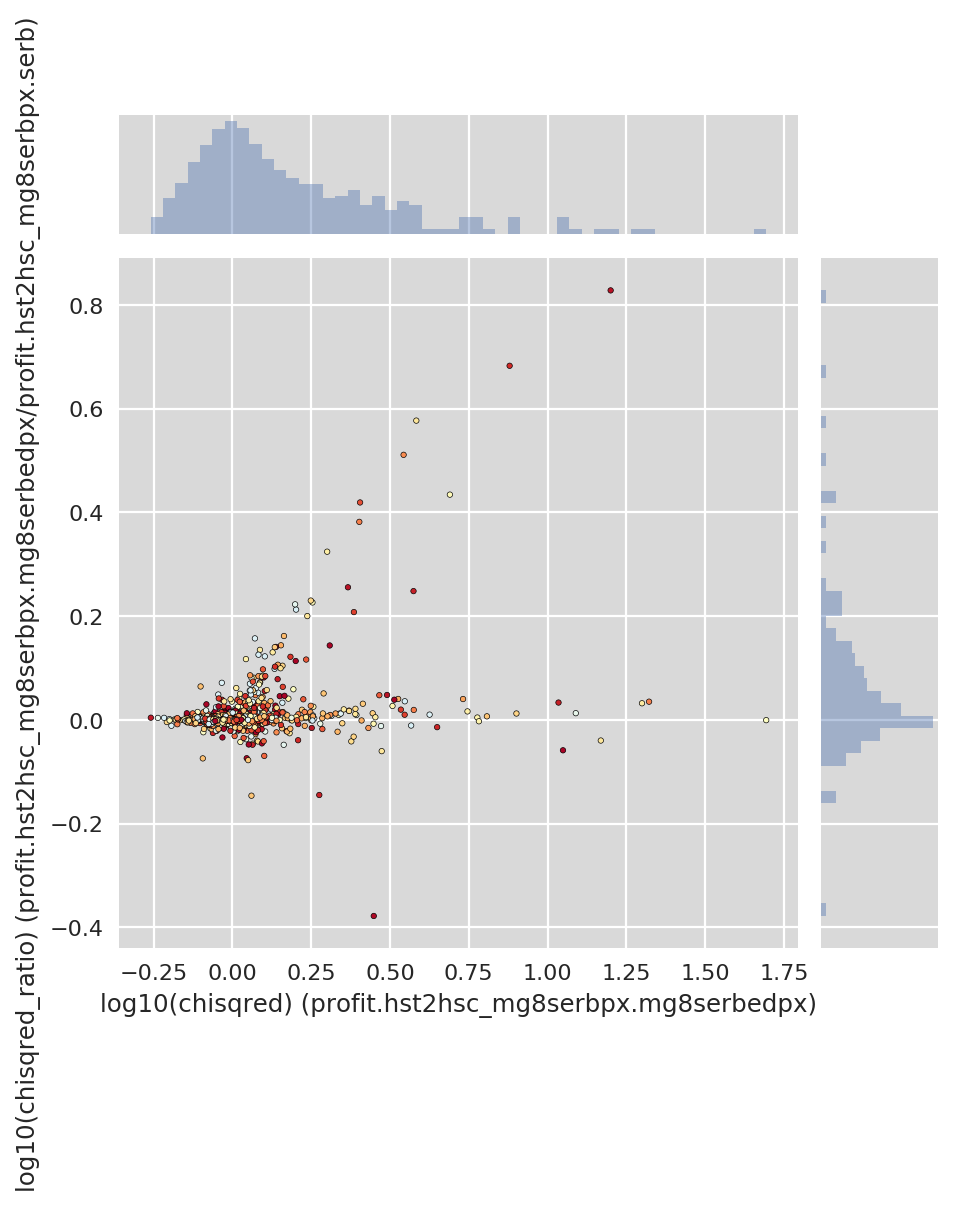

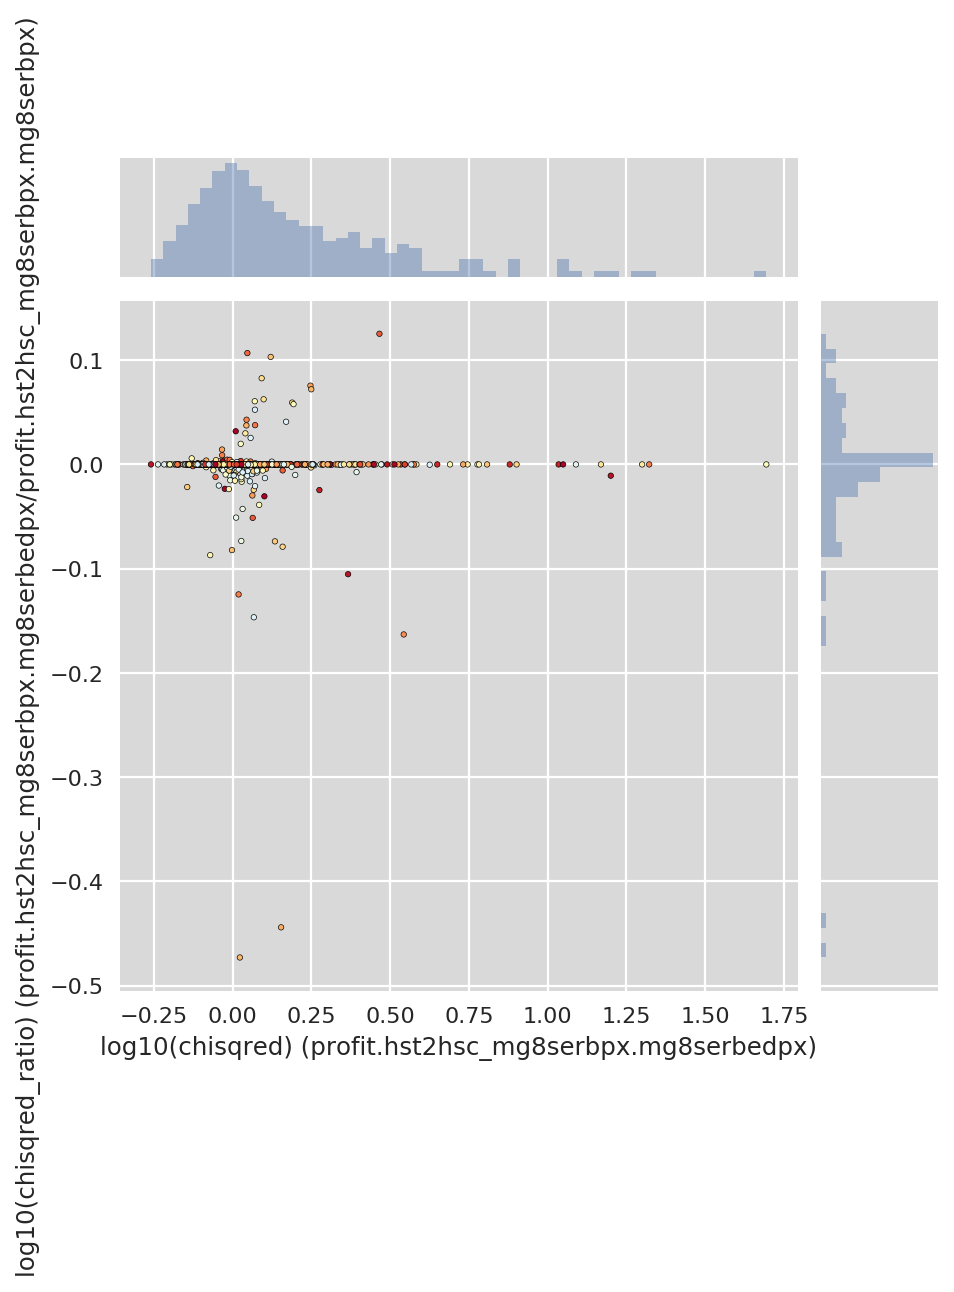

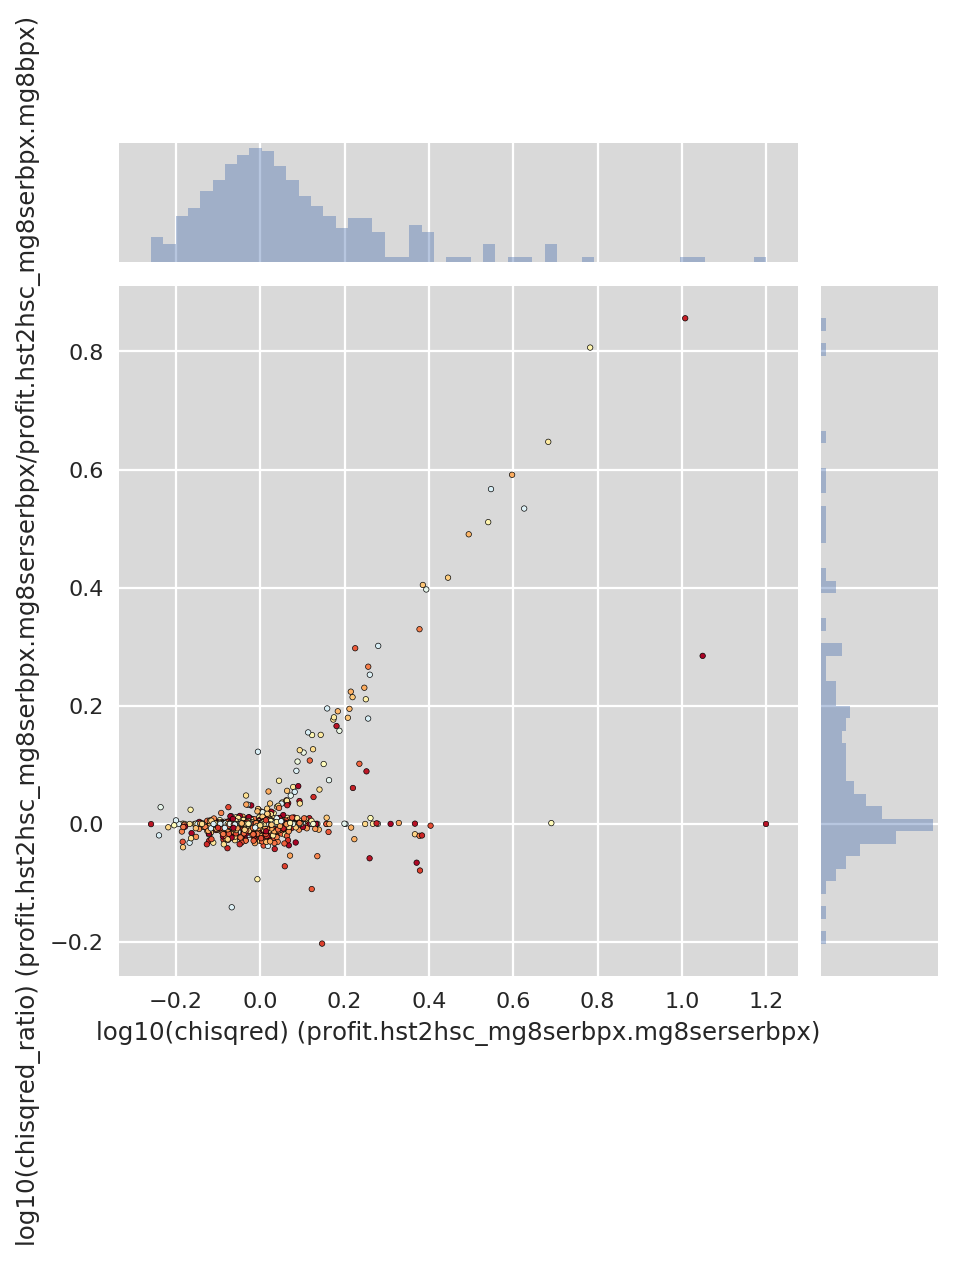

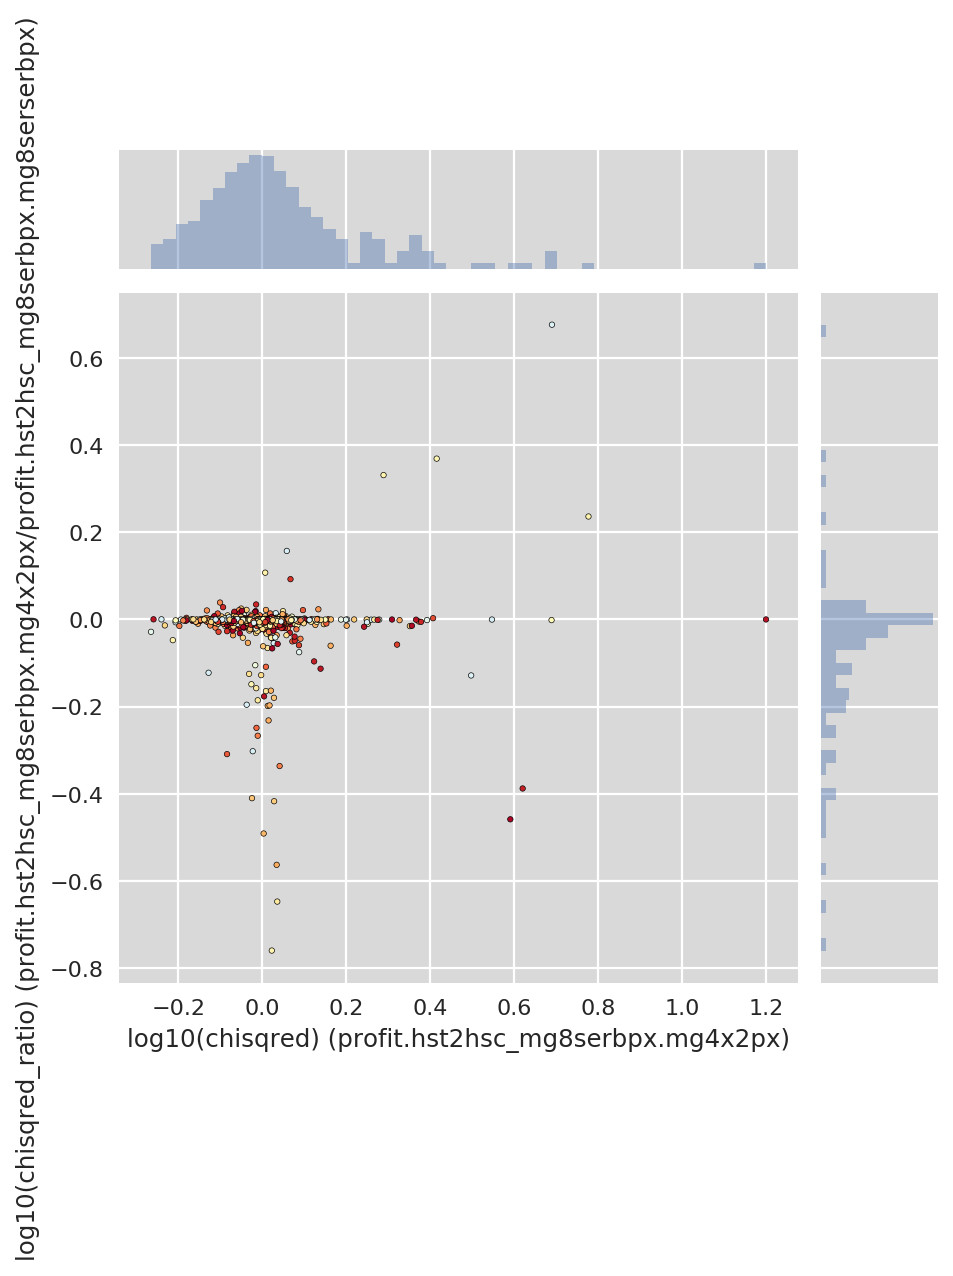

In [16]:
# Which are the best models?

def getpostfix(model):
    return "0" if model in models['single']['profit'] else "1"

modelslist = [
    [model for model in models["single"]["profit"] if not model.startswith('serb')] + [model for model in models["double"]["profit"] if not model.endswith('serserbpx')],
    models["single"]["profit"] + [model for model in models["double"]["profit"] if not model.endswith('serserbpx')] + models['mg']['profit'],
    models["single"]["profit"] + models["double"]["profit"] + models['mg']['profit'],
]
chisqredcols = {}
for modelsprofit in modelslist:
    chisqredcolsprint = {}
    for model in modelsprofit:
        if model not in chisqredcols:
            chisqredcols[model] = ".".join(["profit", "hst", model, "chisqred", getpostfix(model)])
        chisqredcolsprint[model] = chisqredcols[model]
    print(chisqredcolsprint)
    modelbest = tab[list(chisqredcolsprint.values())].idxmin(axis=1)
    modelbestcounts = modelbest.value_counts()
    print(modelbestcounts)

# Plot direct model comparisons
for obs in ['hst', 'hst2hsc_mg8serbpx']:
    for colx, coly in [("mg8serbpx", "mg8devexppx"), ("mg8serbedpx", "mg8cmodelpx"), 
                       ("mg8devexppx", "mg8cmodelpx"), ("mg8serbedpx", "serb"),
                       ("mg8serbedpx", "mg8serbpx"), ("mg8serserbpx", "mg8bpx"),
                       ("mg4x2px", "mg8serserbpx")]:
        prefixx = ".".join(["profit", obs, colx])
        prefixy = ".".join(["profit", obs, coly])
        plotjoint(tab, prefixx, prefixy, ['chisqred'], varcolor="profit.hst.mg8serbpx.n",
                  cmap = mpl.colors.ListedColormap(sns.color_palette("RdYlBu_r", 100)),
                  hist_kws={'log': True}, postfixx=getpostfix(colx), postfixy=getpostfix(coly))

### MG Sersic fixed-n vs free-n fits

These plots compare fixed- versus free-n single Sersic fits. This is to help determine an optimal workflow for fitting increasingly complicated models. For example, the Gaussian model is the fastest to evaluate, but it's also the least likely to be the best fit out of the four fixed-n models (n=0.5, 1, 2, 4).

Another plot compares the goodness of fit for the free-n versus the best-fit fixed-n model, showing that in most cases a fixed-n model is not far off - that is, there are not many galaxies where there's a very significant benefit to fitting n=1.5 or n=3 vs n=2. The exception is the galaxies that prefer n=6 to n=4.

The last plot compares the free Sersic to an exponential, showing that an exponential is 'good enough' for most galaxies except those with best-fit n>4. This suggests that the exponential model would be a reasonable choice if we had to pick just one, which is in line with expectations that most of the galaxies in any given deep field are disky.

profit.hst.mg8exppx.chisqred.0     592
profit.hst.mg8n2px.chisqred.0      479
profit.hst.gausspx.chisqred.0      412
profit.hst.mg8dev2px.chisqred.0    350
dtype: int64


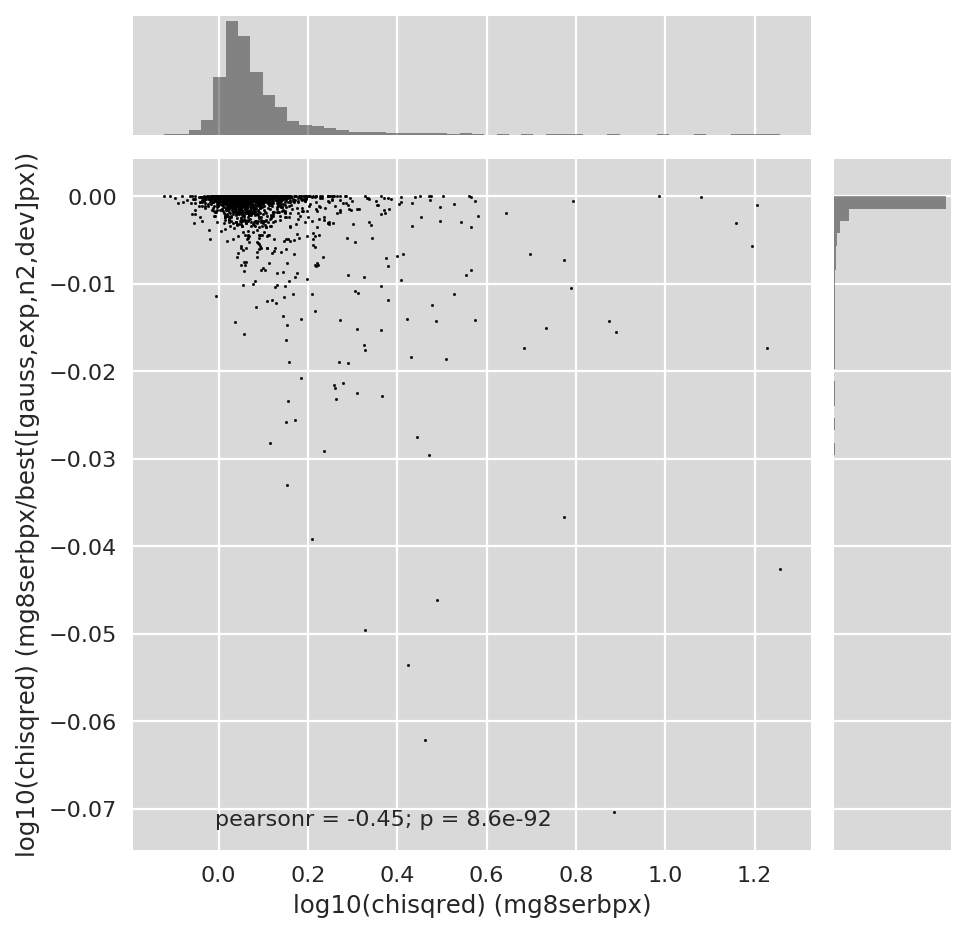

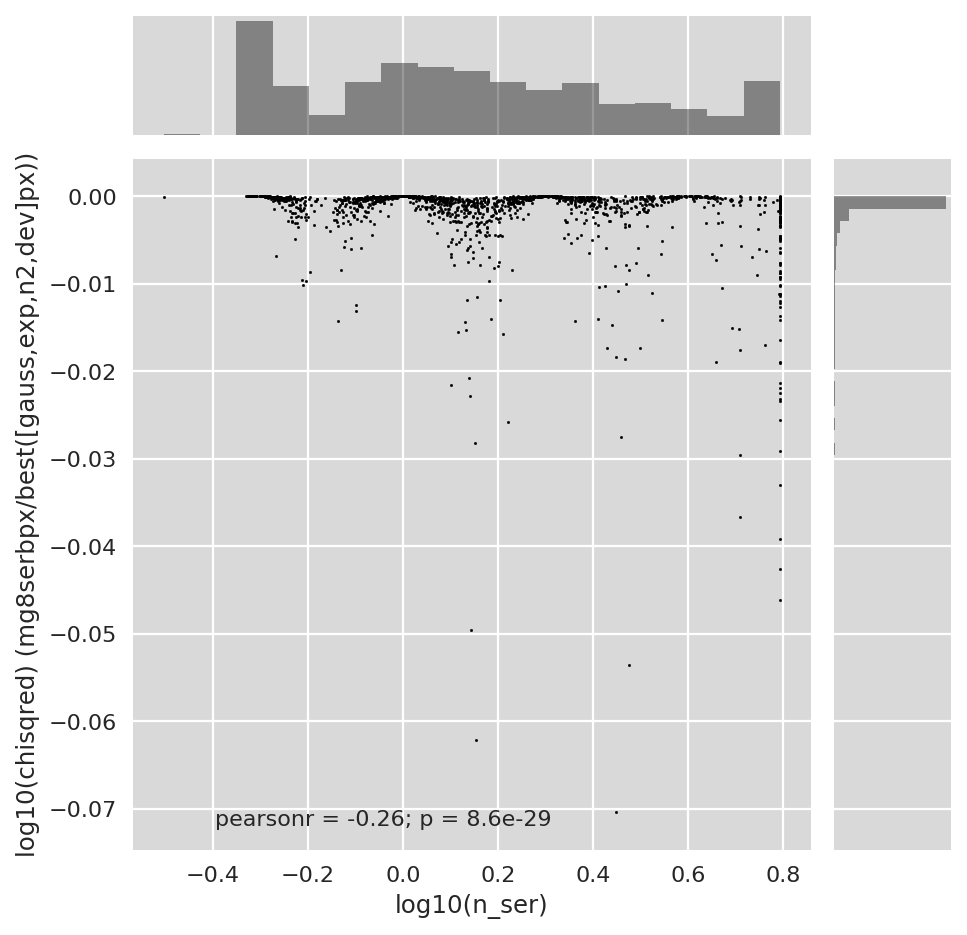

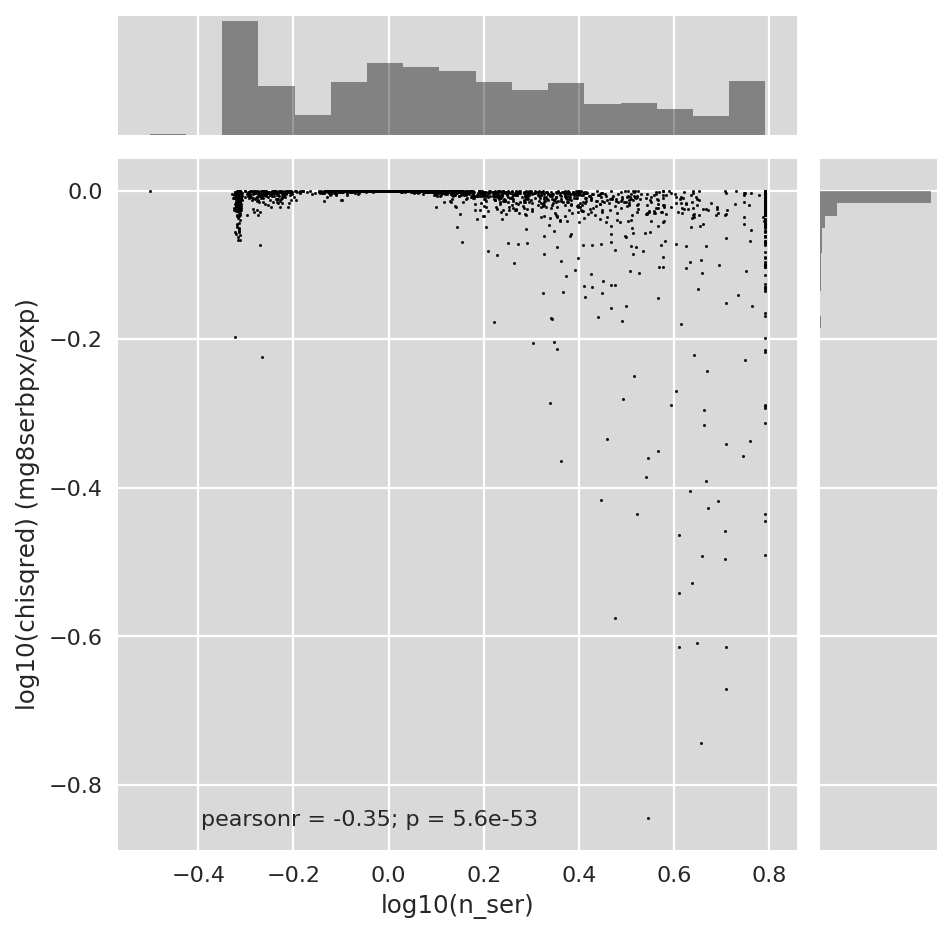

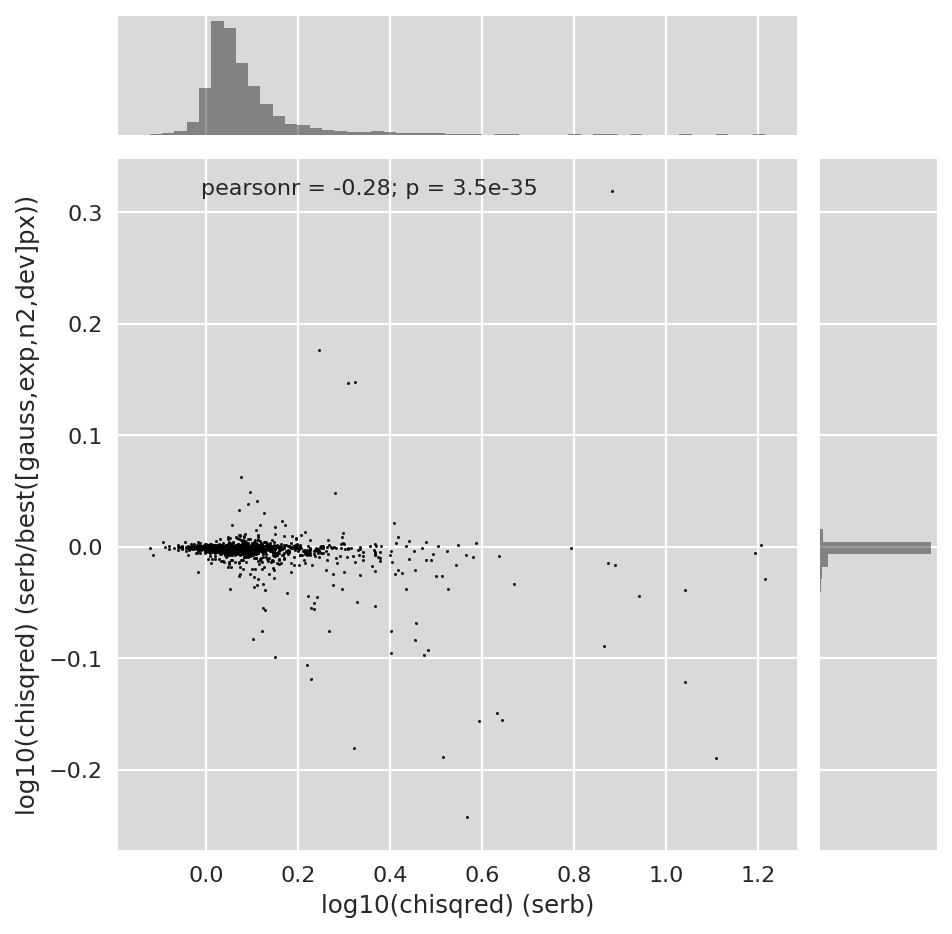

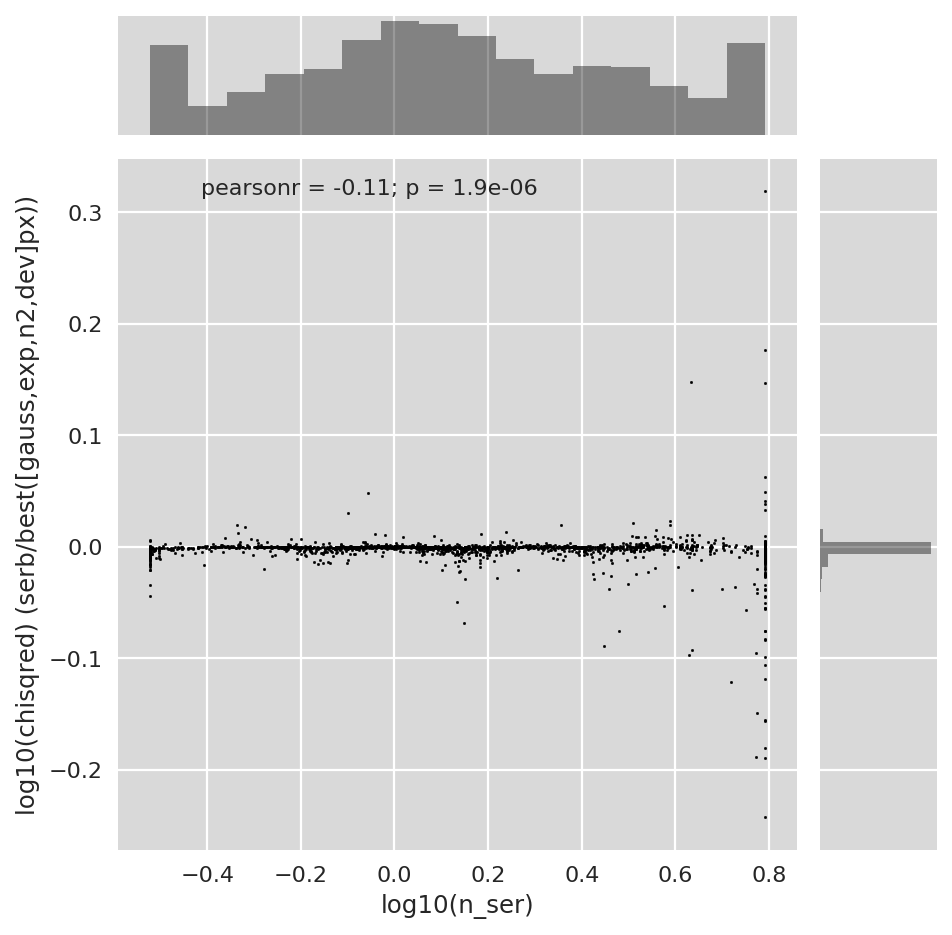

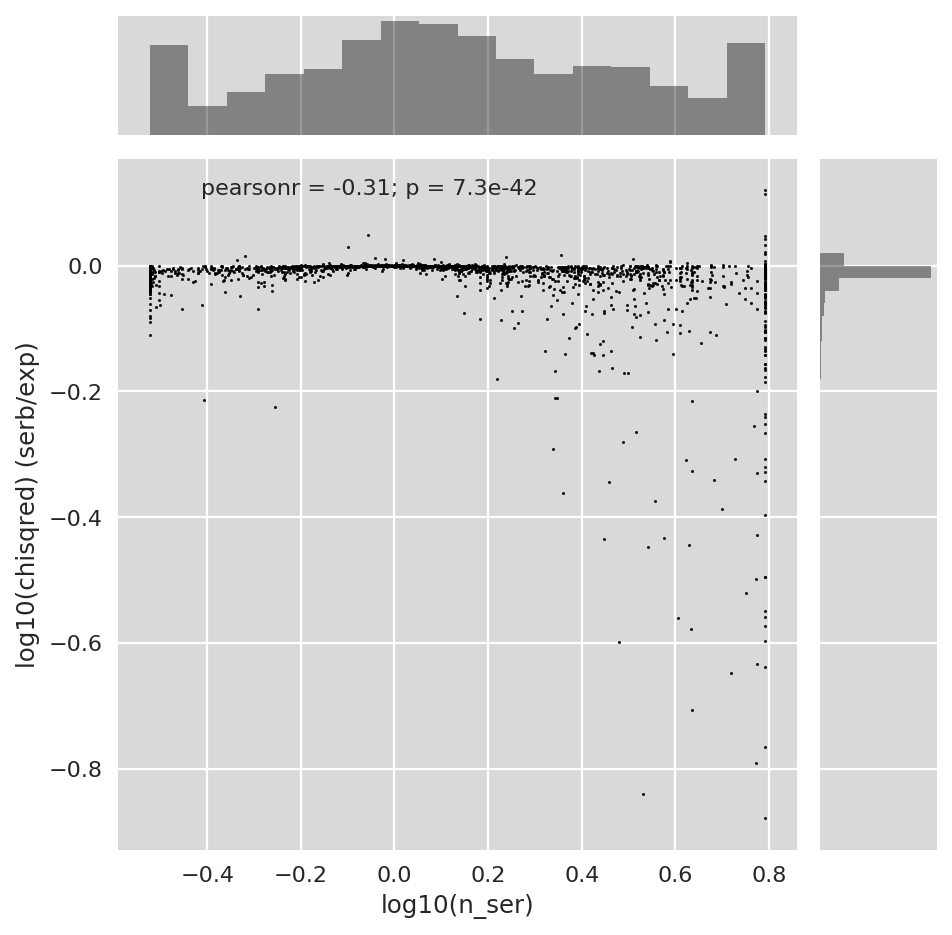

In [17]:
# Now compare only single-component models: Sersic vs best fixed n
modelsfixedn = ["gausspx", "mg8exppx", 'mg8n2px', "mg8dev2px"] 
chisqredcolsfixedn = {
    model: ".".join(["profit", "hst", model, "chisqred", "0"]) 
    for model in modelsfixedn
}
modelbest = tab[list(chisqredcolsfixedn.values())].idxmin(axis=1)
print(modelbest.value_counts())
# I seriously cannot figure out how to slice with modelbest
# Surely there's a better way to do this?
modelchisqmin = tab[list(chisqredcolsfixedn.values())].min(axis=1)
for colxname in ["mg8serbpx", 'serb']: 
    labelbest = 'log10(chisqred) ({}/{})'.format(colxname, "best([gauss,exp,n2,dev]px)")
    ratiobest = tab[chisqredcols[colxname]]/modelchisqmin
    # Plots:
    # How much better is Sersic than the best [gauss/exp/dev] vs how good is the 
    # fit and vs Sersic index
    # As above but vs exp only
    colnser = colxname.join(["profit.hst.", ".n"])
    cols = [
        (tab[chisqredcols[colxname]], ratiobest,
         'log10(chisqred) ({})'.format(colxname), labelbest), 
        (tab[colnser], ratiobest, 'log10(n_ser)', labelbest),
        (tab[colnser], tab[chisqredcols[colxname]]/tab[chisqredcols["mg8exppx"]],
         'log10(n_ser)', 'log10(chisqred) ({}/exp)'.format(colxname)),
    ]
    for x, y, labelx, labely in cols:
        sns.jointplot(
            x=np.log10(x),
            y=np.log10(y),
            color="k", joint_kws={'marker': '.', 's': 4},
            marginal_kws={'hist_kws': {'log': False}},
        ).set_axis_labels(labelx, labely)

### Compare GMM radial profiles to Sersic MGA

Todo. It would make sense to plot the radial profiles of the N=8 GMM and compare it to the MGA Sersic for the same galaxy. 

### Compare model running times

Todo. It would be useful to plot, say, runtime ratio vs chisqred ratio, and identify when and why some model fits take absurdly long times to complete.

The main caveat with this is that both quantities (runtime and goodness of fit) are optimizer-dependent, so it may take more thorough testing of optimization pathways before we can determine whether it's worth fitting models of increasing complexity.

### N=8 vs N=4 Sersic MGA/GMM

Todo. Can we do two-component N=4 GMM? Probably. Perhaps we should test n=4 Sersic MGA (x2) for completeness.

### Multi-band COSMOS-HSC
Todo. It should work in principle, but we'll see.